In [1]:
"""
Data Preprocessing: Loading, Cleaning, and Conflict Handling for Census Income Data

This script performs the following preprocessing steps:
1. Reads raw census income training and test datasets from CSV files.
2. Assigns appropriate column names to the data.
3. Removes exact duplicate rows.
4. Identifies and removes conflicting rows where identical features have different income labels.
5. Converts the income column into a binary classification target variable ("Tag"):
   - Income ≤ 50K → Tag = 0
   - Income > 50K → Tag = 1
6. Drops any rows with unexpected or invalid income values.
7. Prints the number of removed conflicting rows and confirms class distribution.

The resulting cleaned datasets (df_learn_cleaned, df_test_cleaned) will be used for further feature engineering and model training.
"""
import pandas as pd
import numpy as np

# ========== 1) Load Data and Store Initial Counts ==========

learn_path = "D:/Gursel/isguc/DataIku/census_income_learn.csv"
test_path = "D:/Gursel/isguc/DataIku/census_income_test.csv"

column_names = [
    "AAGE", "ACLSWKR", "ADTIND", "ADTOCC", "AHGA", "AHRSPAY", "AHSCOL", "AMARITL", "AMJIND", "AMJOCC",
    "ARACE", "AREORGN", "ASEX", "AUNMEM", "AUNTYPE", "AWKSTAT", "CAPGAIN", "CAPLOSS", "DIVVAL", "FILESTAT",
    "GRINREG", "GRINST", "HHDFMX", "HHDREL", "MARSUPWT", "MIGMTR1", "MIGMTR3", "MIGMTR4", "MIGSAME", "MIGSUN",
    "NOEMP", "PARENT", "PEFNTVTY", "PEMNTVTY", "PENATVTY", "PRCITSHP", "PTOTVAL", "SEOTR", "VETQVA", "WKSWORK",
    "year", "income"
]

print("=== Loading Data ===")
df_learn = pd.read_csv(learn_path, header=None, names=column_names)
df_test = pd.read_csv(test_path, header=None, names=column_names)

initial_learn = df_learn.shape[0]
initial_test = df_test.shape[0]
print(f"Initial training rows: {initial_learn}")
print(f"Initial test rows: {initial_test}\n")


# ========== 2) Remove Exact Duplicates ==========

dupes_learn_before = df_learn.shape[0]
df_learn.drop_duplicates(inplace=True)
dupes_learn_after = df_learn.shape[0]
duplicates_removed_learn = dupes_learn_before - dupes_learn_after

dupes_test_before = df_test.shape[0]
df_test.drop_duplicates(inplace=True)
dupes_test_after = df_test.shape[0]
duplicates_removed_test = dupes_test_before - dupes_test_after

print("=== Duplicates Removed ===")
print(f"Training duplicates removed: {duplicates_removed_learn}")
print(f"Test duplicates removed: {duplicates_removed_test}\n")


# ========== 3) Detect and Remove Conflicting Rows ==========

# Features excluding 'MARSUPWT' and 'income'
feature_columns = [col for col in df_learn.columns if col not in ["MARSUPWT", "income"]]

# Helper columns for conflict detection
df_learn['combined_features'] = df_learn[feature_columns].apply(tuple, axis=1)
df_test['combined_features'] = df_test[feature_columns].apply(tuple, axis=1)

# --- Training conflicts ---
duplicates_learn = df_learn.duplicated(subset='combined_features', keep=False)
duplicated_subset_learn = df_learn[duplicates_learn]

conflict_counts_learn = duplicated_subset_learn.groupby('combined_features')['income'].nunique()
conflicting_features_learn = conflict_counts_learn[conflict_counts_learn > 1].index

train_conflict_before = df_learn.shape[0]
df_learn_cleaned = df_learn[~df_learn['combined_features'].isin(conflicting_features_learn)].copy()
train_conflict_after = df_learn_cleaned.shape[0]
conflicts_removed_learn = train_conflict_before - train_conflict_after

# --- Test conflicts ---
duplicates_test = df_test.duplicated(subset='combined_features', keep=False)
duplicated_subset_test = df_test[duplicates_test]

conflict_counts_test = duplicated_subset_test.groupby('combined_features')['income'].nunique()
conflicting_features_test = conflict_counts_test[conflict_counts_test > 1].index

test_conflict_before = df_test.shape[0]
df_test_cleaned = df_test[~df_test['combined_features'].isin(conflicting_features_test)].copy()
test_conflict_after = df_test_cleaned.shape[0]
conflicts_removed_test = test_conflict_before - test_conflict_after

# Drop the helper column
df_learn_cleaned.drop(columns=['combined_features'], inplace=True)
df_test_cleaned.drop(columns='combined_features', inplace=True)

print("=== Conflict Rows Removed ===")
print(f"Training conflicts removed: {conflicts_removed_learn}")
print(f"Test conflicts removed: {conflicts_removed_test}\n")


# ========== 4) Convert 'income' to 'Tag' and Remove Invalid Values ==========

def convert_income(val):
    val_str = str(val).strip().replace('.', '').replace(' ', '')
    if val_str == "-50000":
        return 0
    elif val_str == "50000+":
        return 1
    else:
        return np.nan

df_learn_cleaned['Tag'] = df_learn_cleaned['income'].apply(convert_income)
df_test_cleaned['Tag'] = df_test_cleaned['income'].apply(convert_income)

invalid_train = df_learn_cleaned['Tag'].isna().sum()
invalid_test = df_test_cleaned['Tag'].isna().sum()

print("=== Unexpected/Invalid Incomes ===")
print(f"Training rows with invalid 'income': {invalid_train}")
print(f"Test rows with invalid 'income': {invalid_test}\n")

if invalid_train > 0:
    df_learn_cleaned.dropna(subset=['Tag'], inplace=True)

if invalid_test > 0:
    df_test_cleaned.dropna(subset=['Tag'], inplace=True)


# ========== 5) Final Summary of Rows Removed ==========

final_learn_count = df_learn_cleaned.shape[0]
final_test_count = df_test_cleaned.shape[0]

total_removed_learn = initial_learn - final_learn_count
total_removed_test = initial_test - final_test_count

print("=== Final Summary ===")
print(f"Initial training rows: {initial_learn}")
print(f"Final training rows: {final_learn_count}")
print(f"Total removed from training: {total_removed_learn}  (Duplicates: {duplicates_removed_learn}, Conflicts: {conflicts_removed_learn}, Invalid Income: {invalid_train})\n")

print(f"Initial test rows: {initial_test}")
print(f"Final test rows: {final_test_count}")
print(f"Total removed from test: {total_removed_test}  (Duplicates: {duplicates_removed_test}, Conflicts: {conflicts_removed_test}, Invalid Income: {invalid_test})")

# Check final distribution of 'Tag'
print("\nTraining 'Tag' distribution after cleaning:")
print(df_learn_cleaned['Tag'].value_counts(dropna=False))
print("\nTest 'Tag' distribution after cleaning:")
print(df_test_cleaned['Tag'].value_counts(dropna=False))

=== Loading Data ===
Initial training rows: 199523
Initial test rows: 99762

=== Duplicates Removed ===
Training duplicates removed: 3229
Test duplicates removed: 883

=== Conflict Rows Removed ===
Training conflicts removed: 379
Test conflicts removed: 119

=== Unexpected/Invalid Incomes ===
Training rows with invalid 'income': 0
Test rows with invalid 'income': 0

=== Final Summary ===
Initial training rows: 199523
Final training rows: 195915
Total removed from training: 3608  (Duplicates: 3229, Conflicts: 379, Invalid Income: 0)

Initial test rows: 99762
Final test rows: 98760
Total removed from test: 1002  (Duplicates: 883, Conflicts: 119, Invalid Income: 0)

Training 'Tag' distribution after cleaning:
Tag
0    183627
1     12288
Name: count, dtype: int64

Test 'Tag' distribution after cleaning:
Tag
0    92612
1     6148
Name: count, dtype: int64


In [2]:
# Basic Statistics & Data Overview

def basic_eda(df, name="Dataset"):
    print(f"--- {name} ---")
    # Shape
    print(f"Shape: {df.shape}")
    # Data types
    print("\nData types:")
    print(df.dtypes)
    # Missing values ('?') per column
    missing_counts = (df == '?').sum()
    missing_counts_nonzero = missing_counts[missing_counts > 0]
    print("\nMissing values ('?') per column:")
    print(missing_counts_nonzero)
    # Total missing values
    print(f"\nTotal missing ('?') values: {missing_counts_nonzero.sum()}")

# Apply basic EDA to datasets
basic_eda(df_learn_cleaned, "Training Dataset")
basic_eda(df_test_cleaned, "Test Dataset")

# Class imbalance
print("\n--- Class Distribution (Tag) ---")
print("Training Set:")
print(df_learn_cleaned['Tag'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

print("\nTest Set:")
print(df_test_cleaned['Tag'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

--- Training Dataset ---
Shape: (195915, 43)

Data types:
AAGE          int64
ACLSWKR      object
ADTIND        int64
ADTOCC        int64
AHGA         object
AHRSPAY       int64
AHSCOL       object
AMARITL      object
AMJIND       object
AMJOCC       object
ARACE        object
AREORGN      object
ASEX         object
AUNMEM       object
AUNTYPE      object
AWKSTAT      object
CAPGAIN       int64
CAPLOSS       int64
DIVVAL        int64
FILESTAT     object
GRINREG      object
GRINST       object
HHDFMX       object
HHDREL       object
MARSUPWT    float64
MIGMTR1      object
MIGMTR3      object
MIGMTR4      object
MIGSAME      object
MIGSUN       object
NOEMP         int64
PARENT       object
PEFNTVTY     object
PEMNTVTY     object
PENATVTY     object
PRCITSHP     object
PTOTVAL       int64
SEOTR        object
VETQVA        int64
WKSWORK       int64
year          int64
income       object
Tag           int64
dtype: object

Missing values ('?') per column:
Series([], dtype: int64)

Total mi

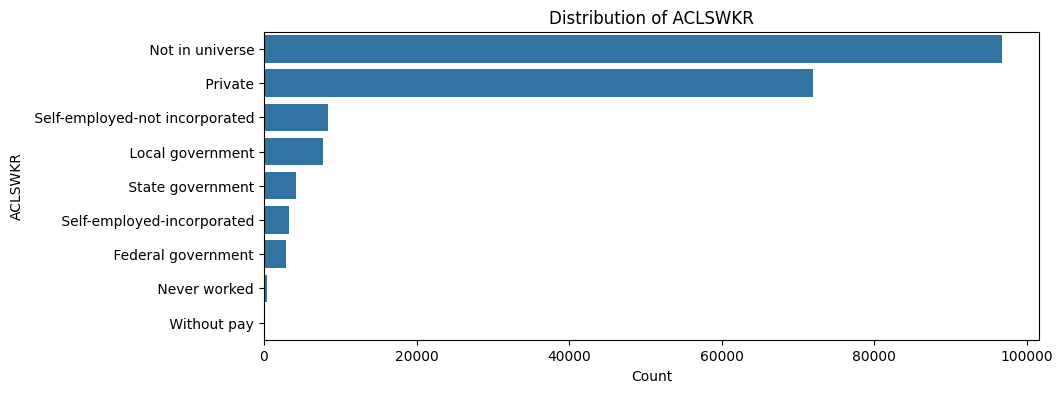

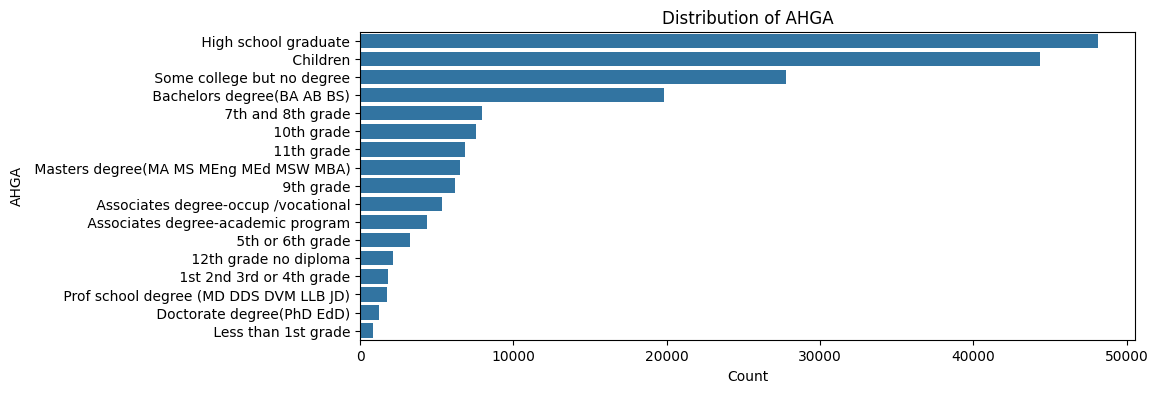

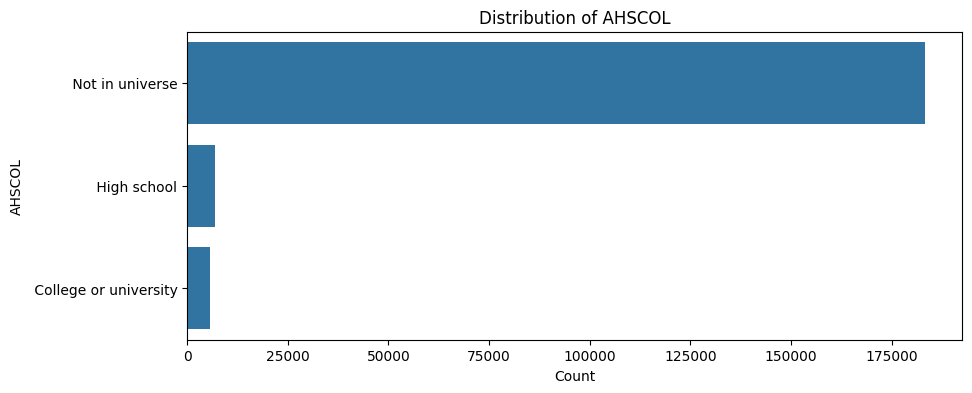

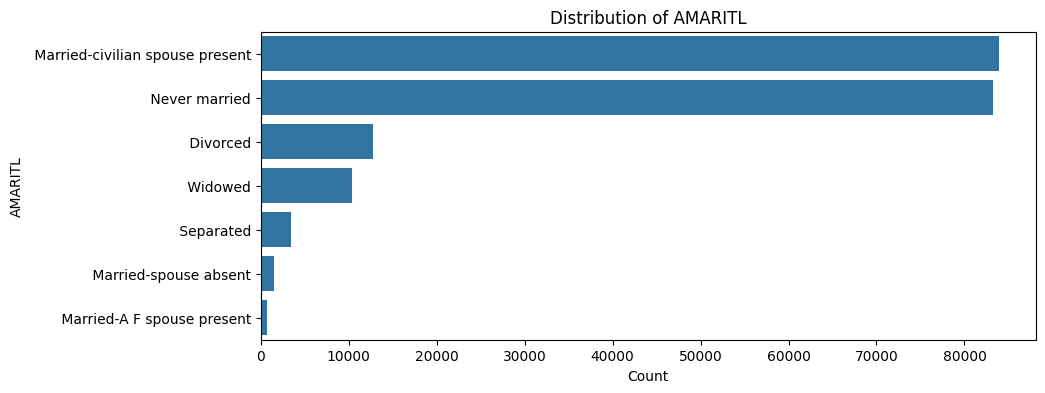

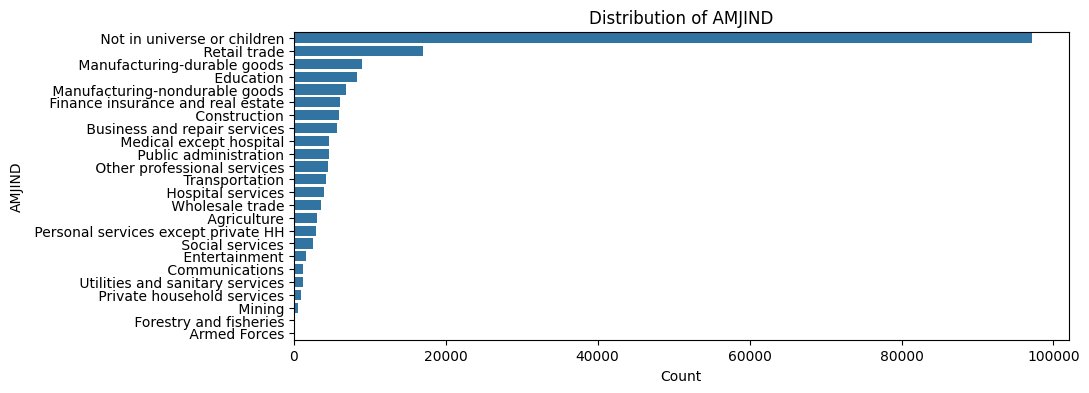

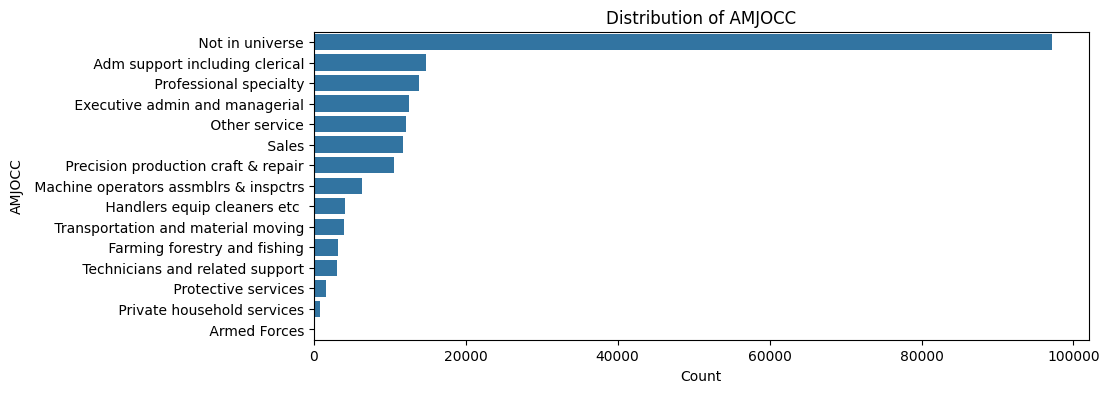

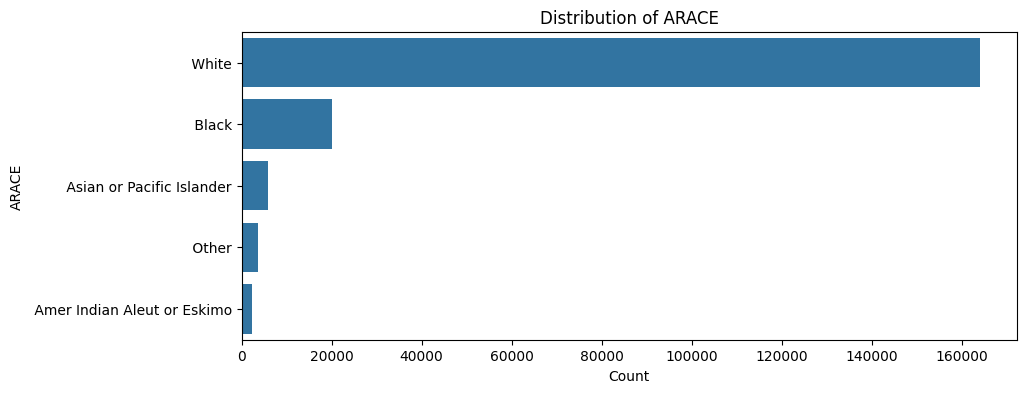

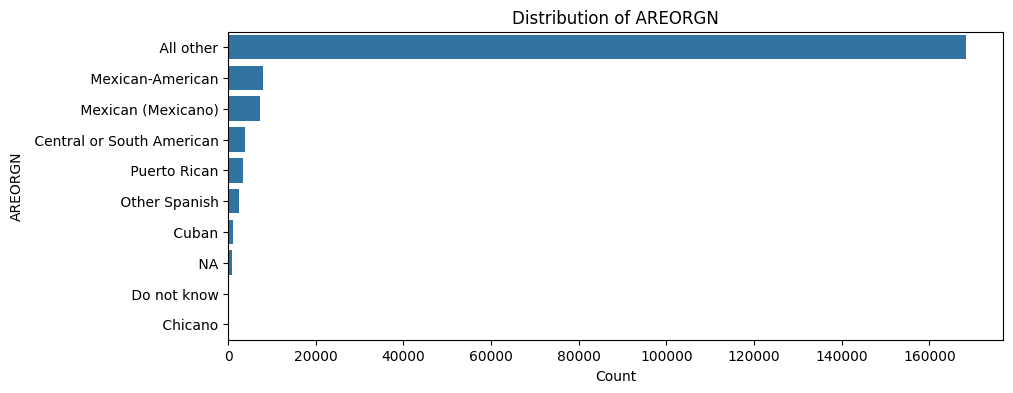

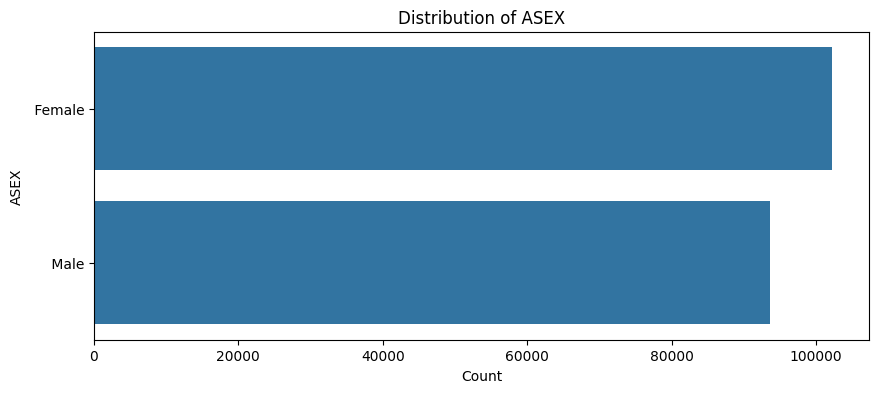

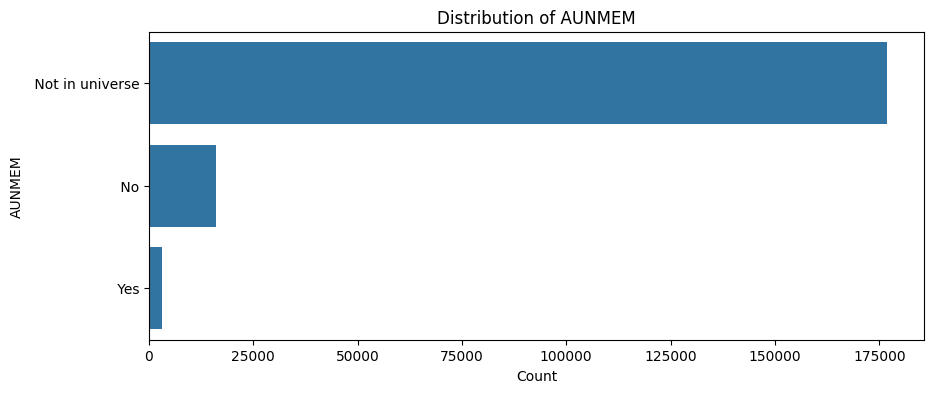

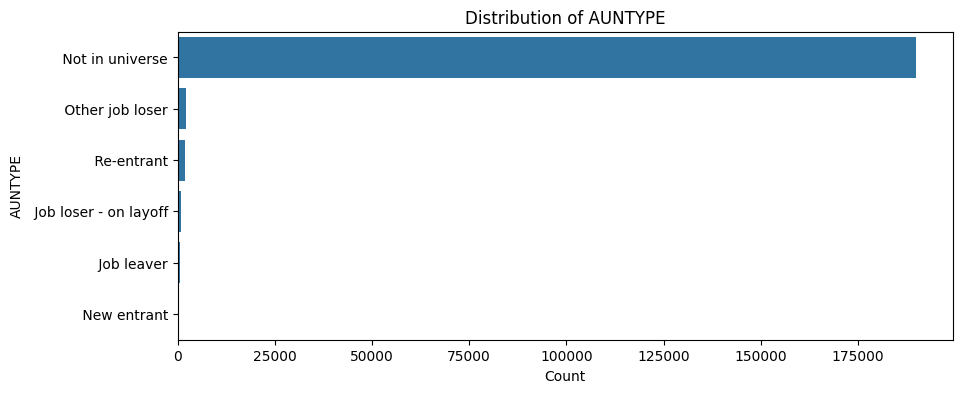

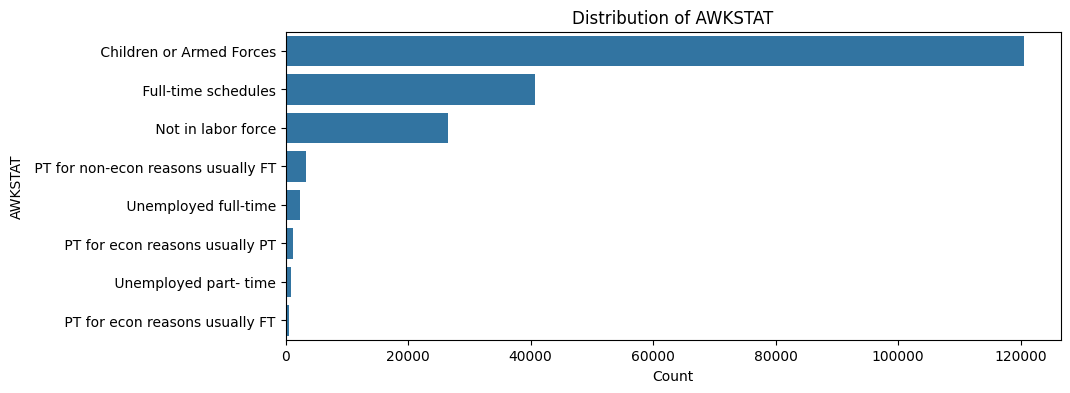

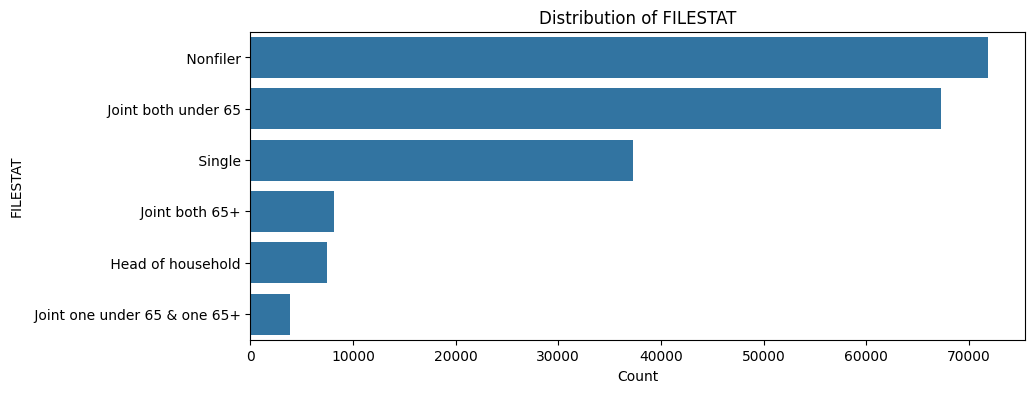

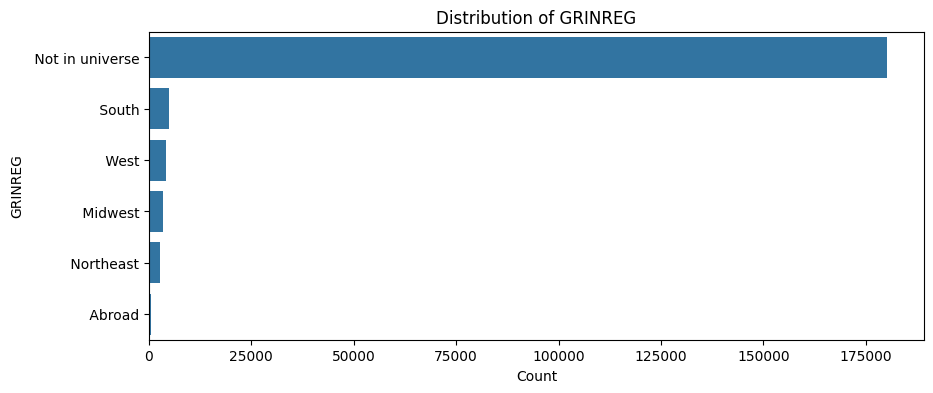

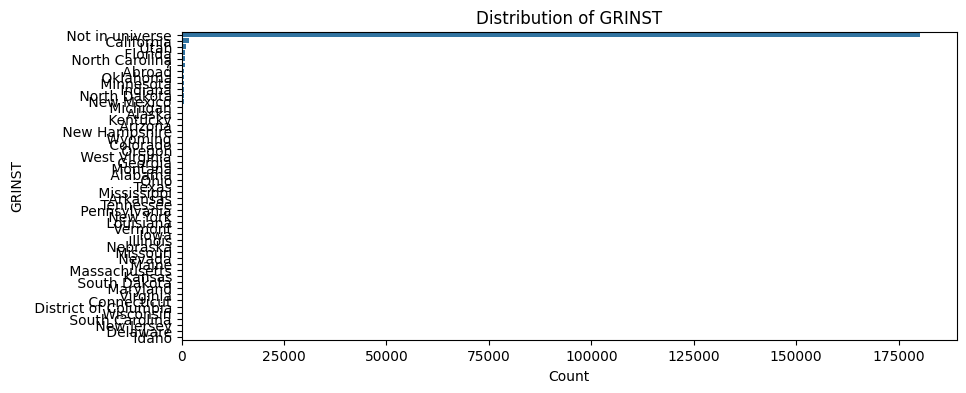

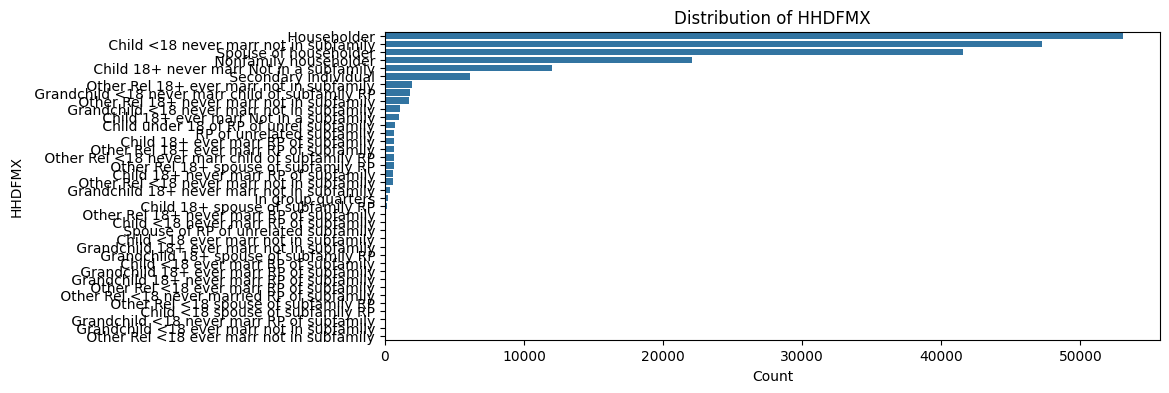

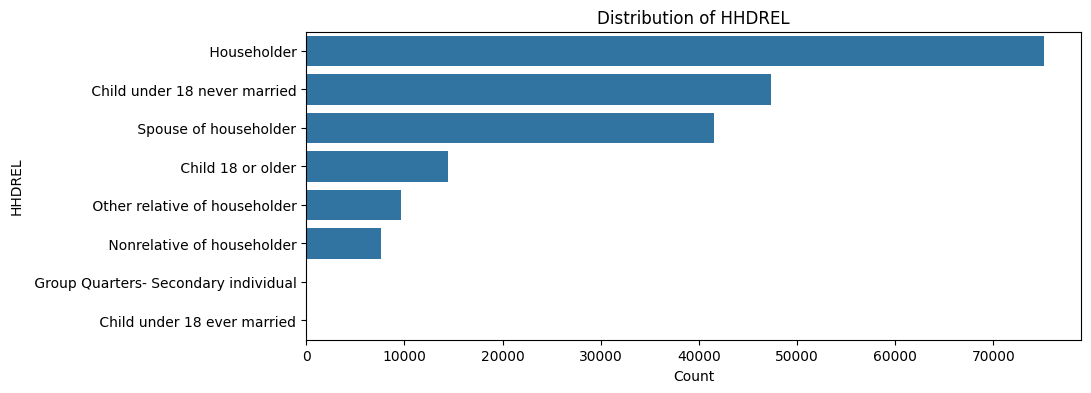

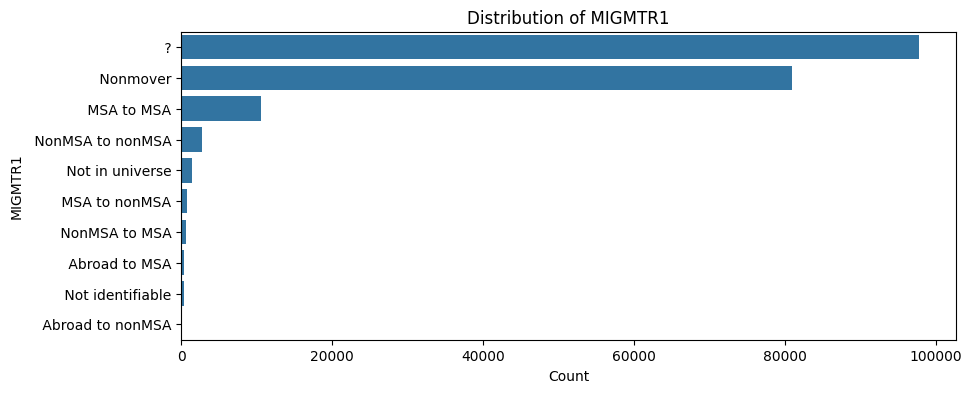

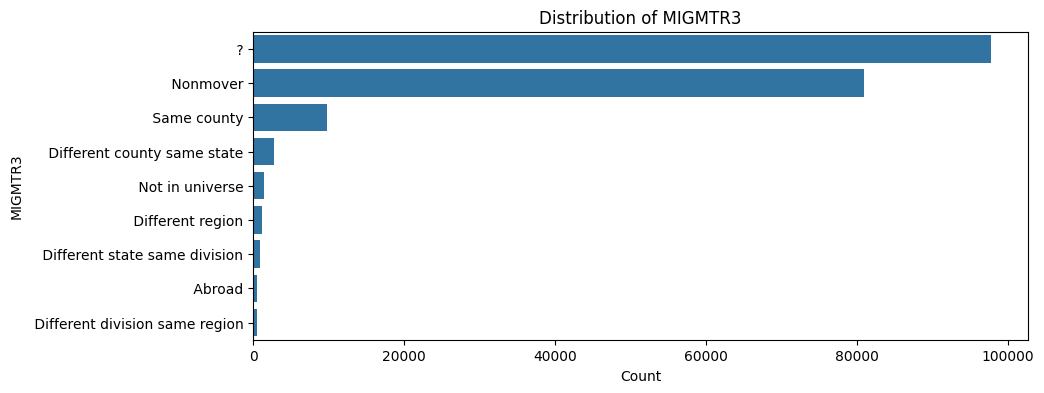

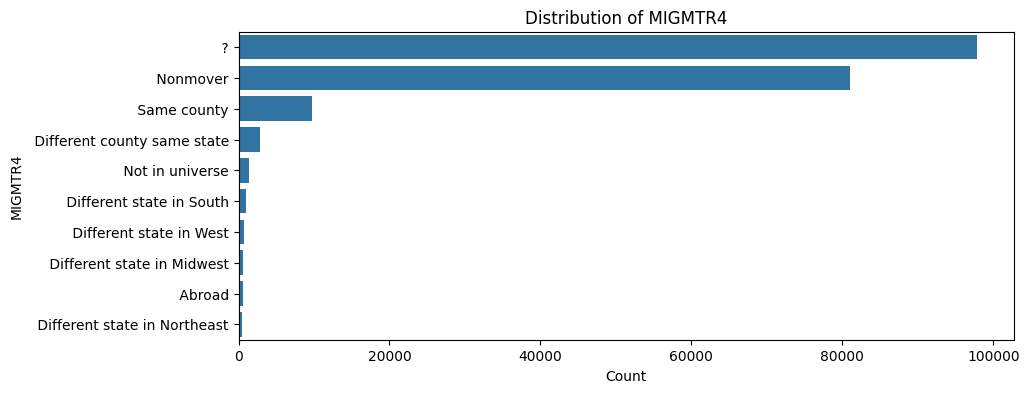

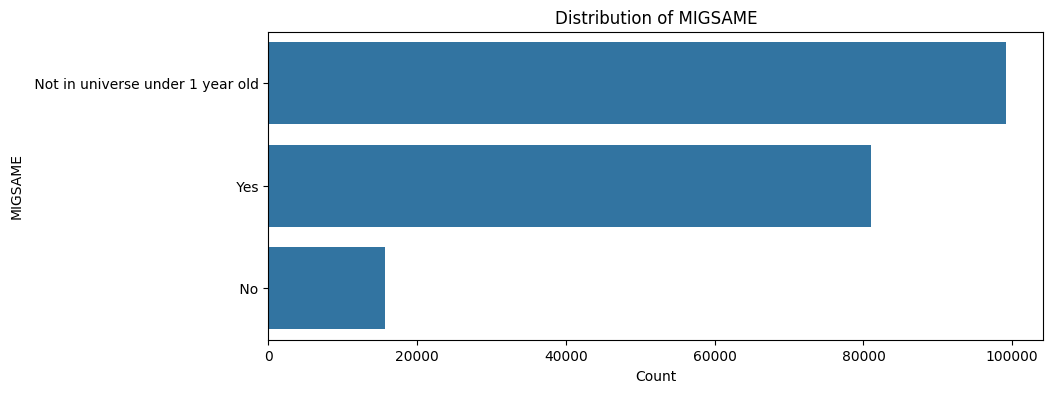

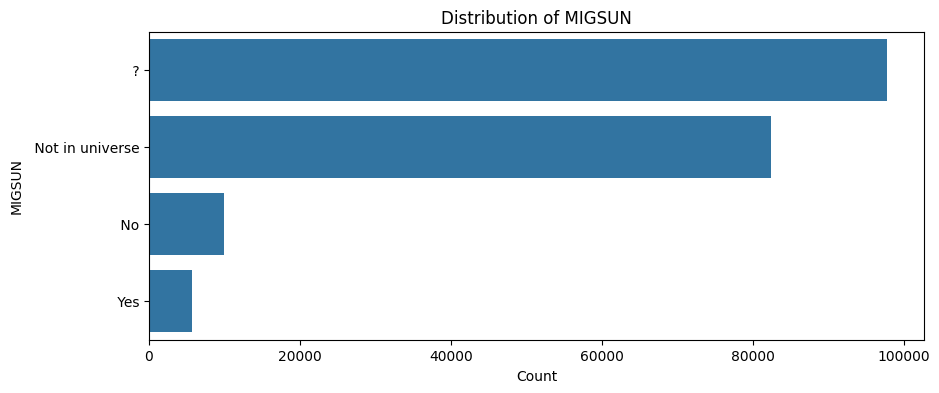

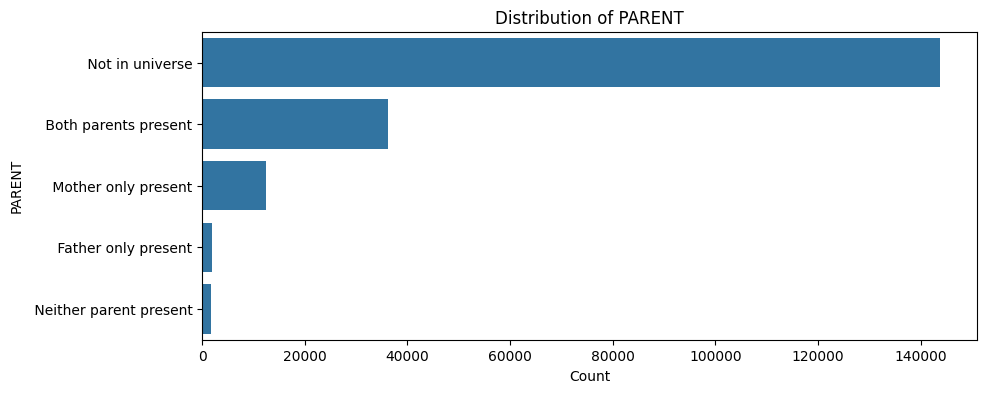

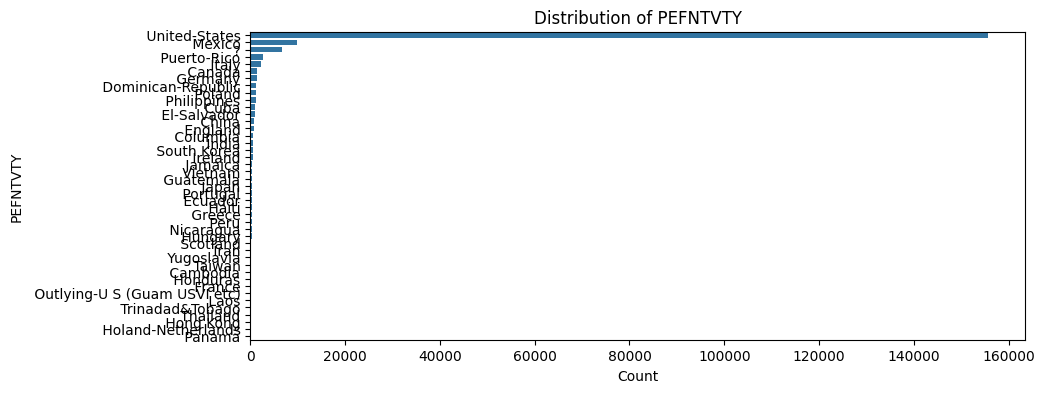

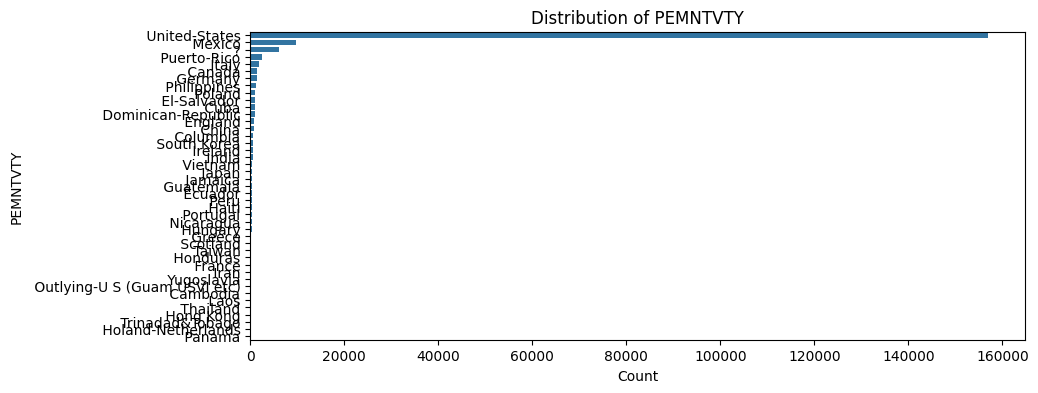

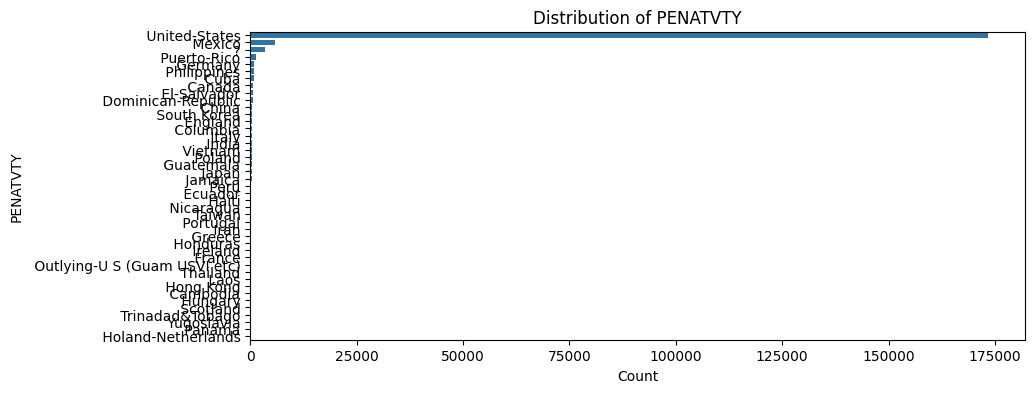

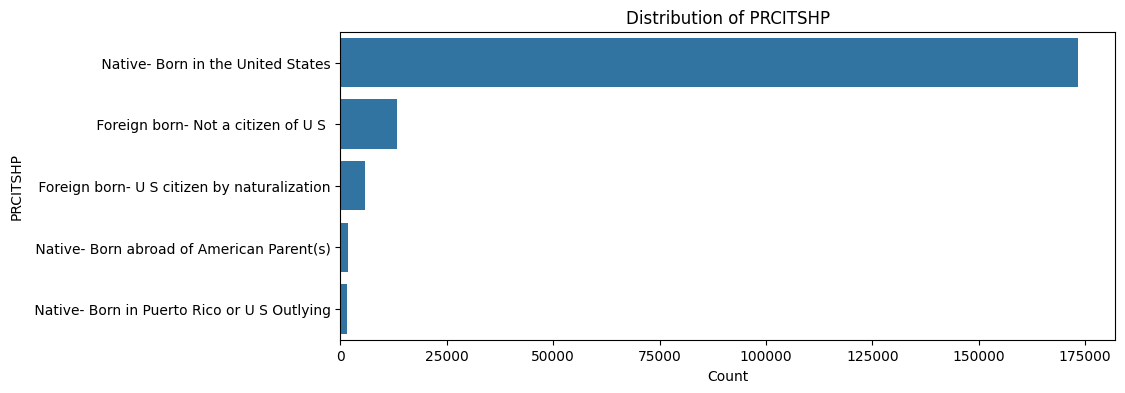

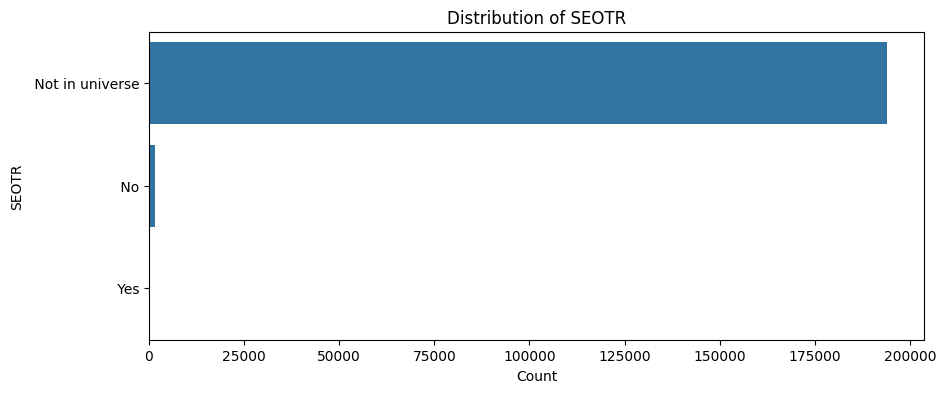

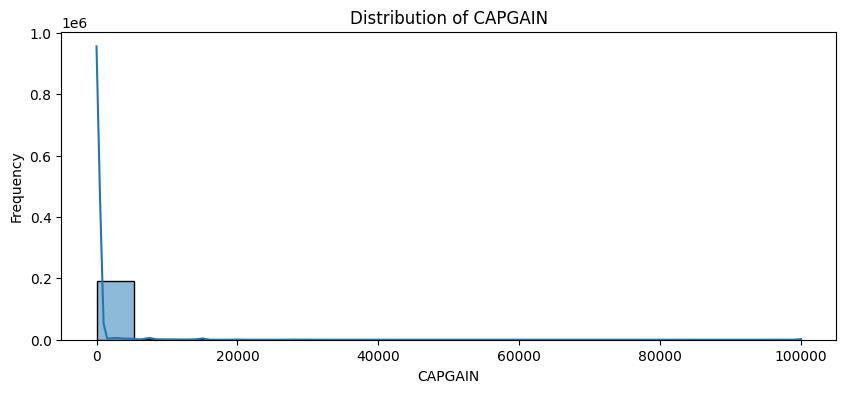

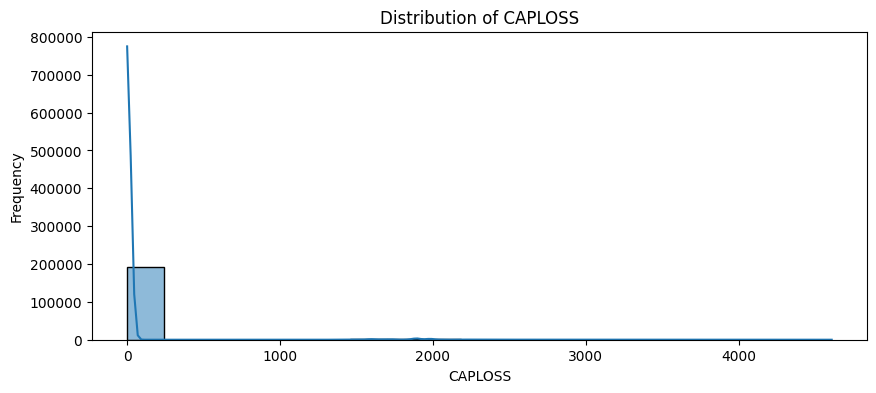

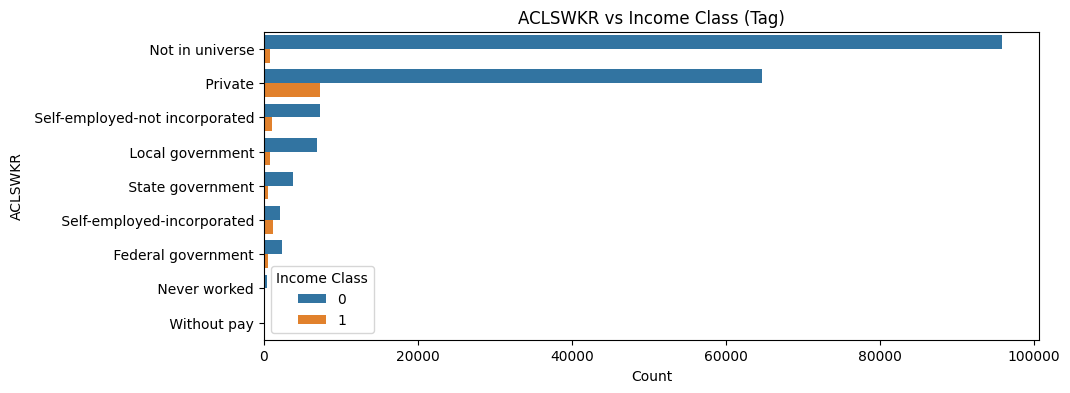

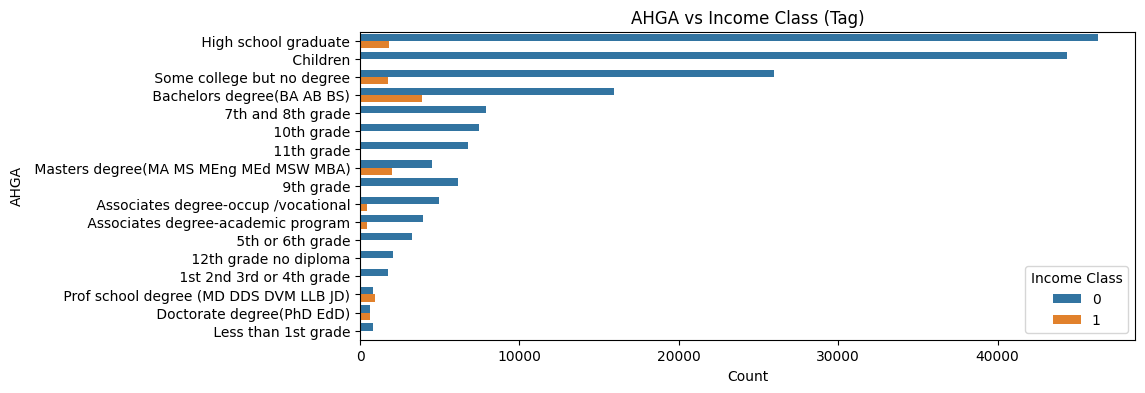

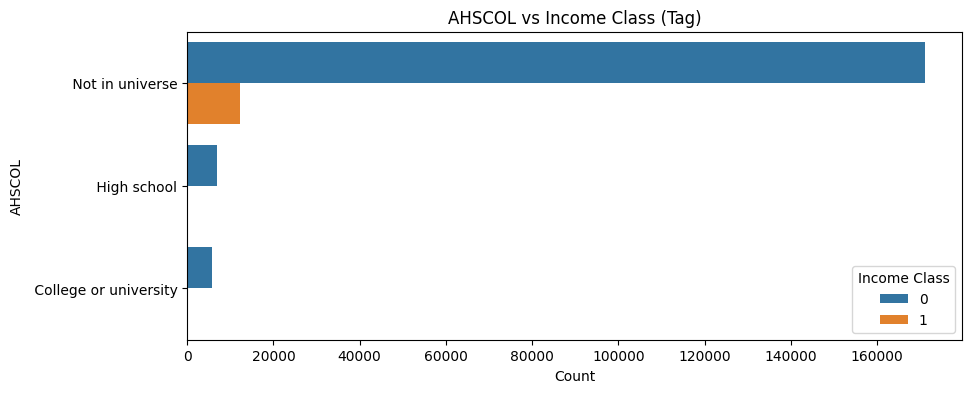

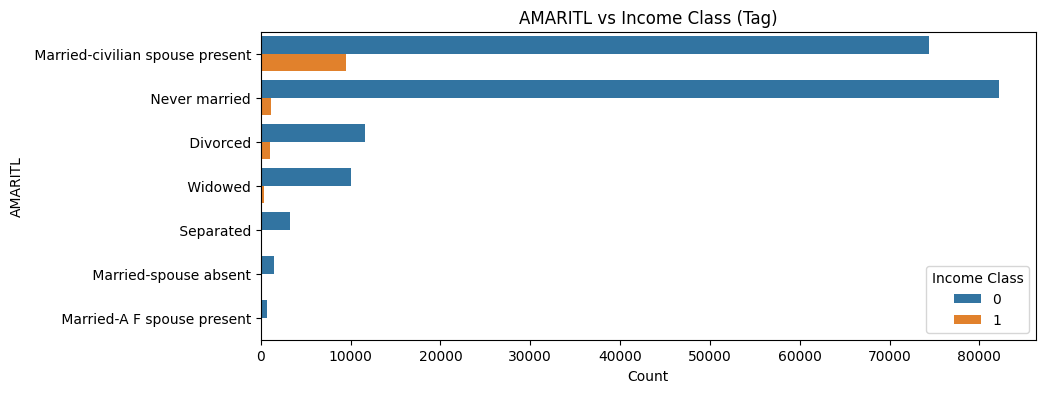

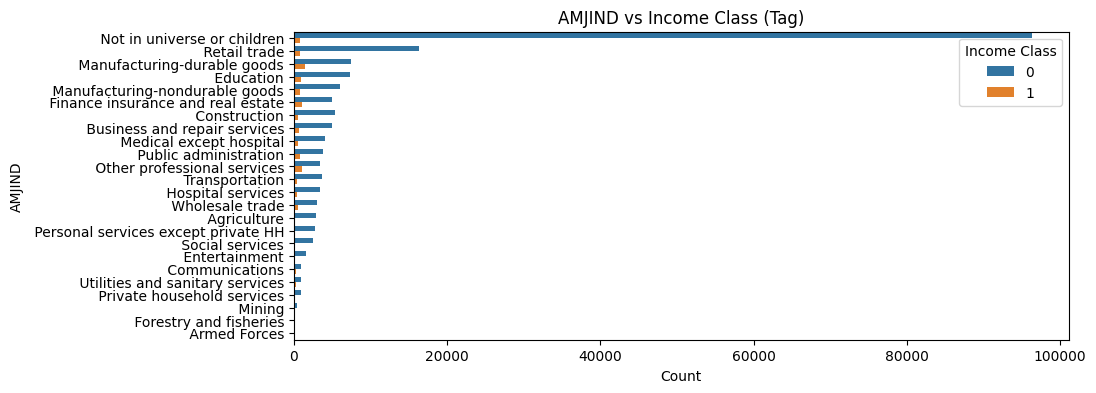

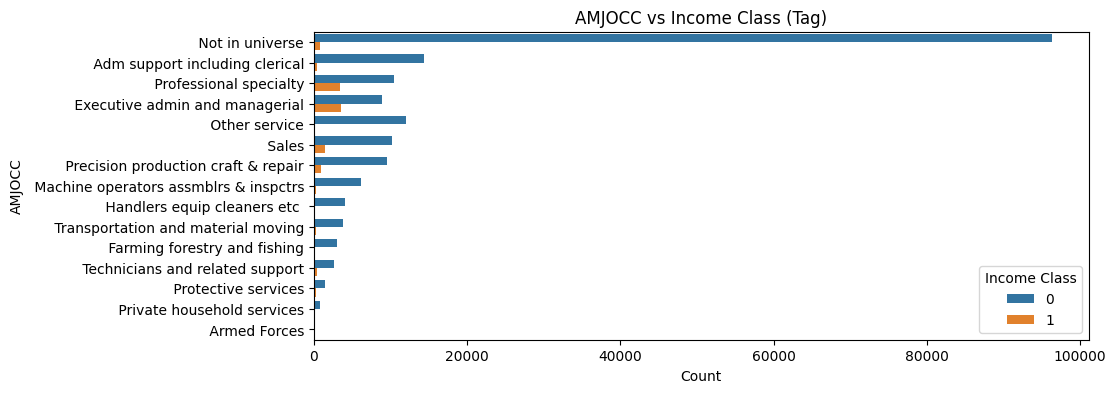

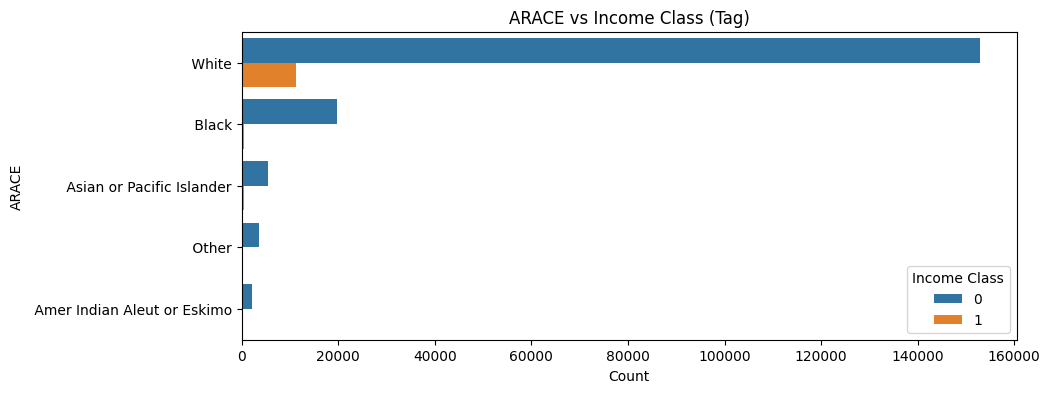

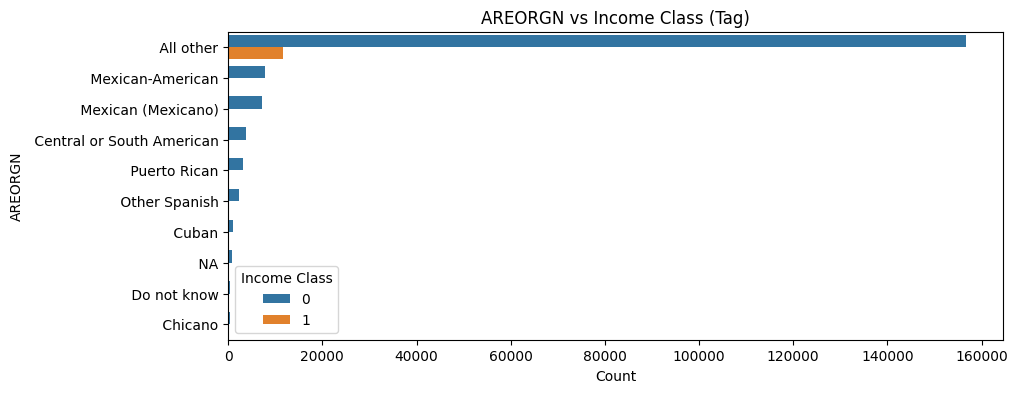

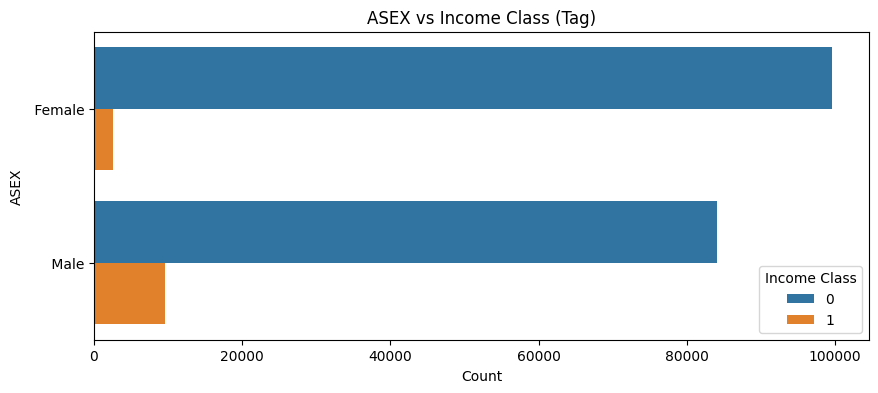

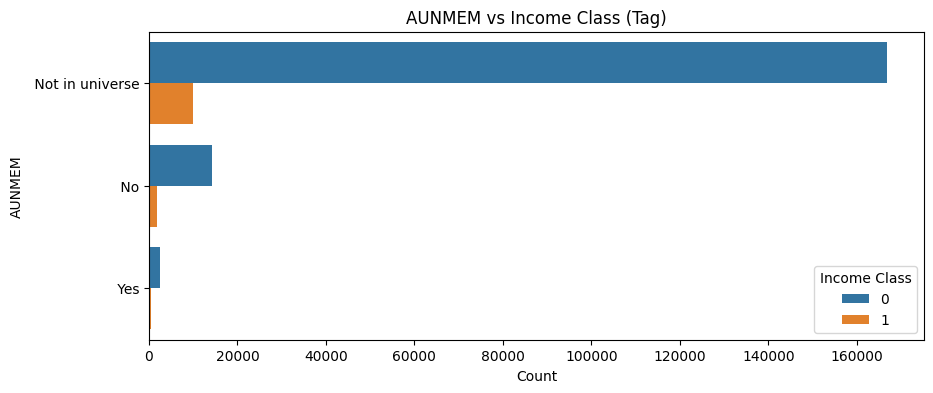

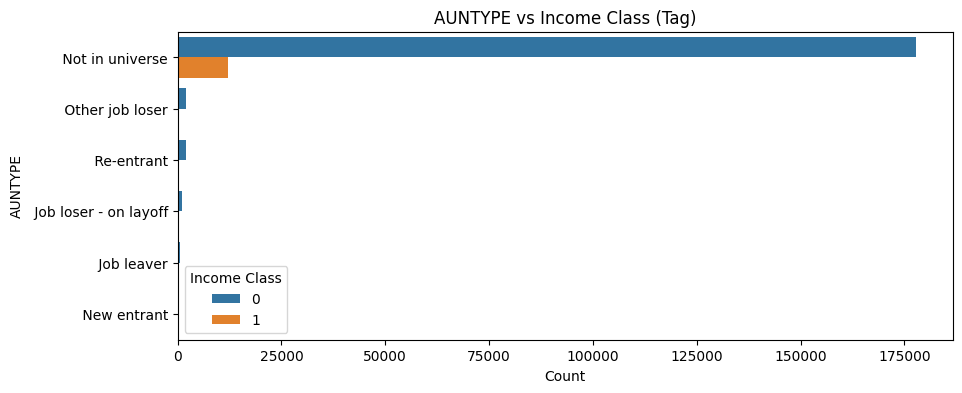

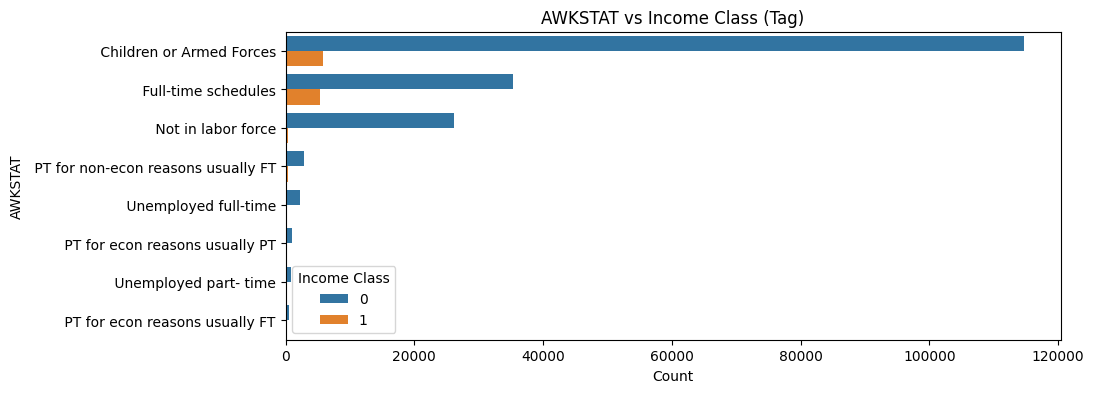

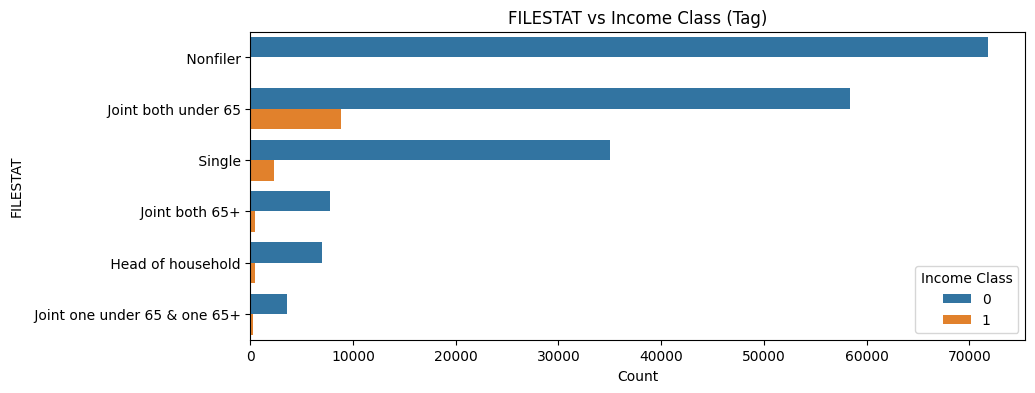

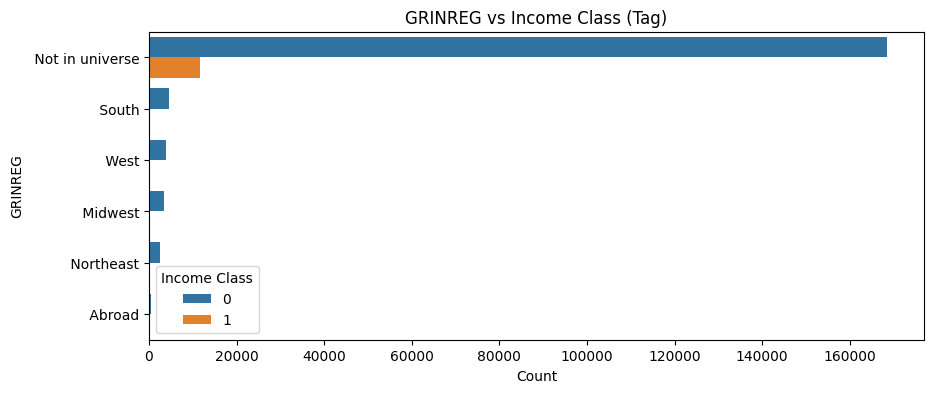

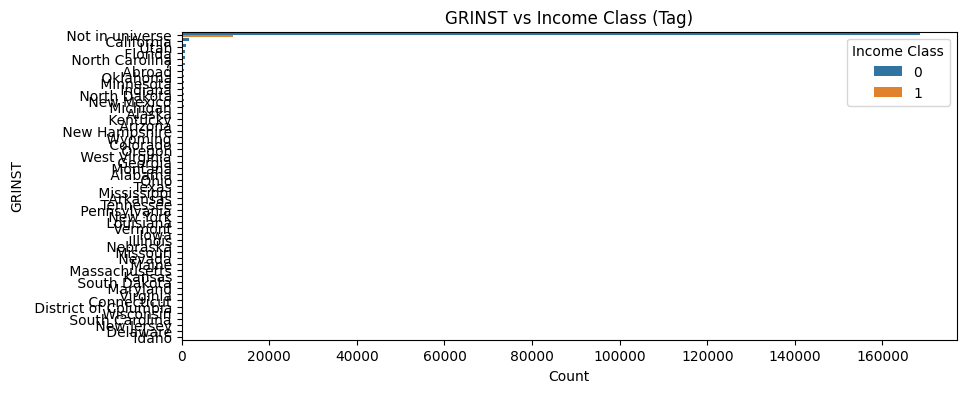

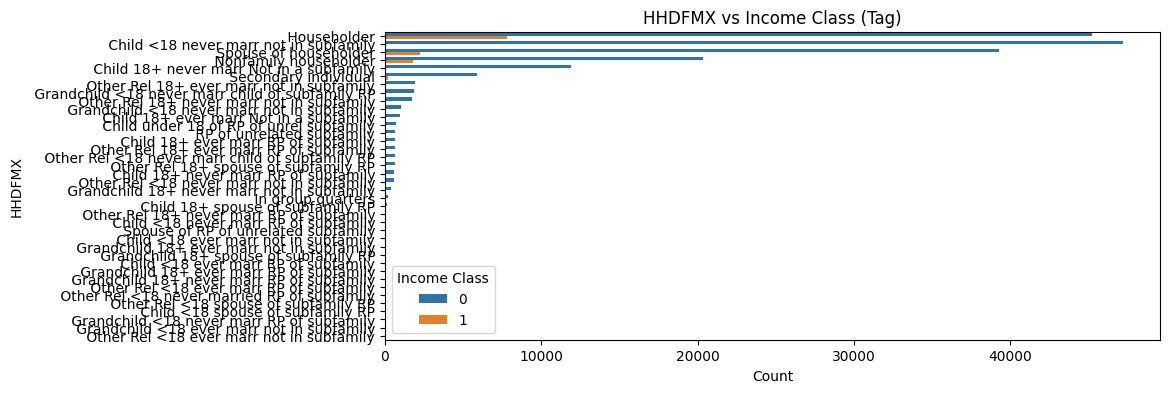

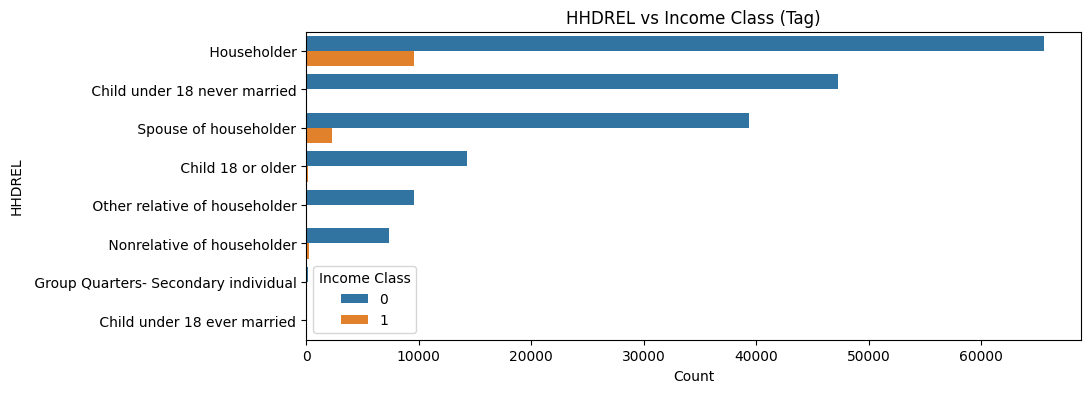

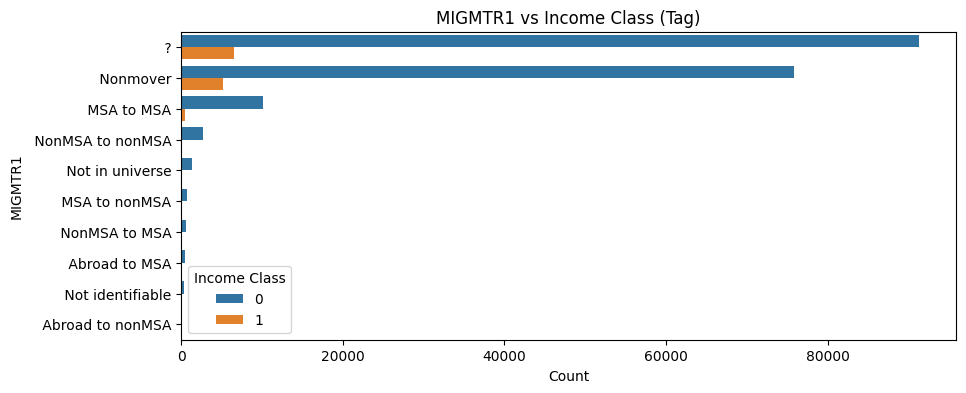

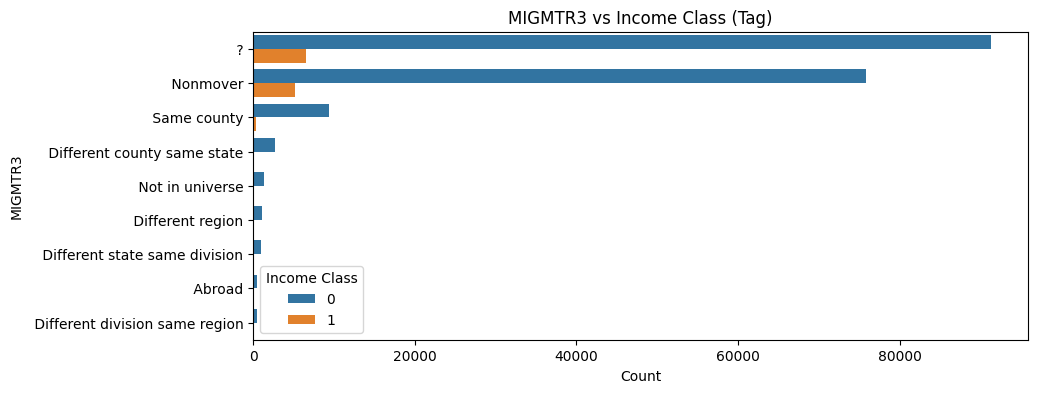

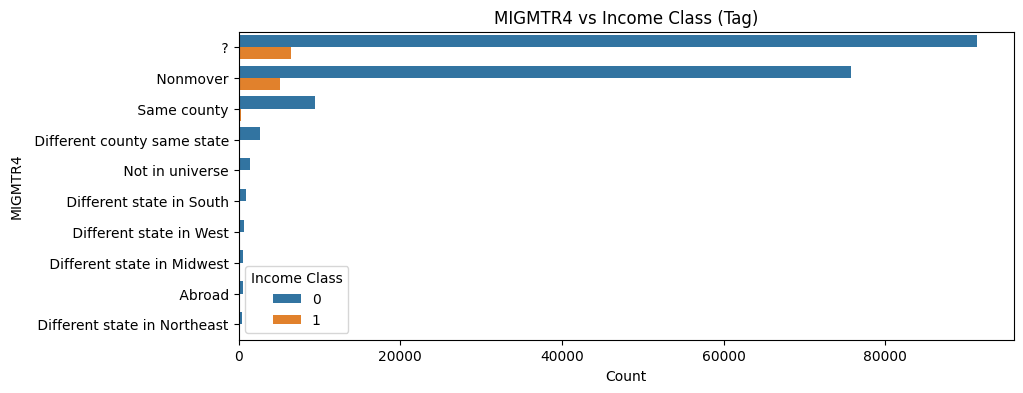

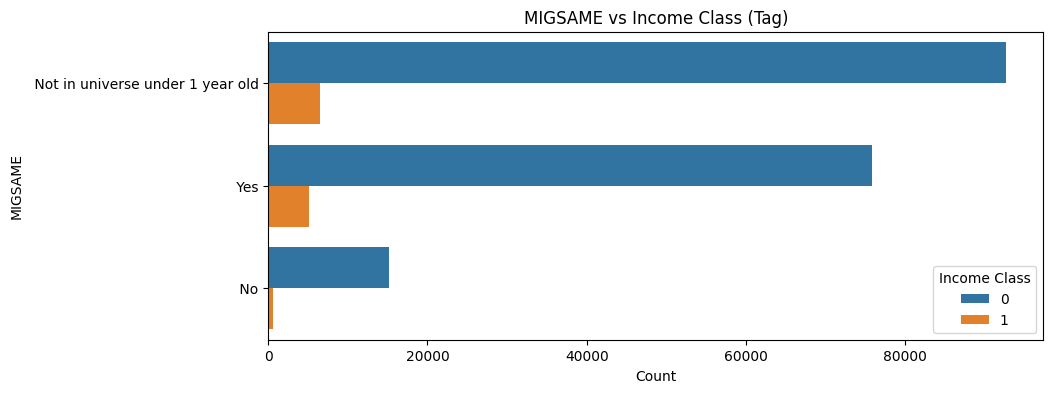

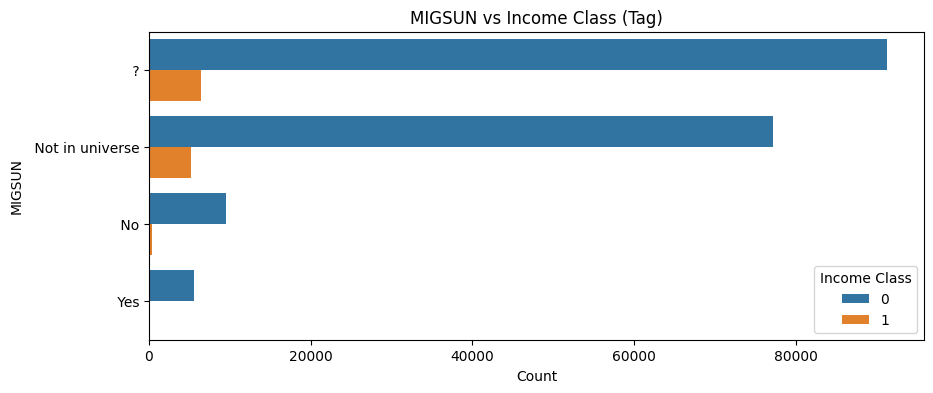

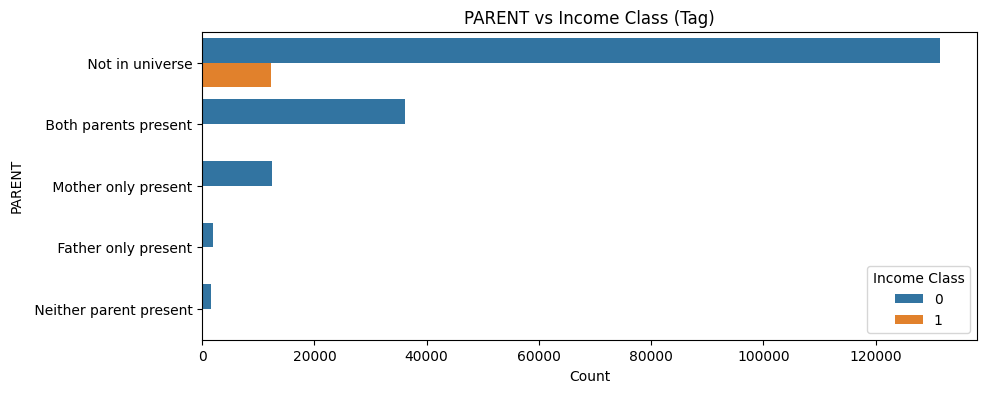

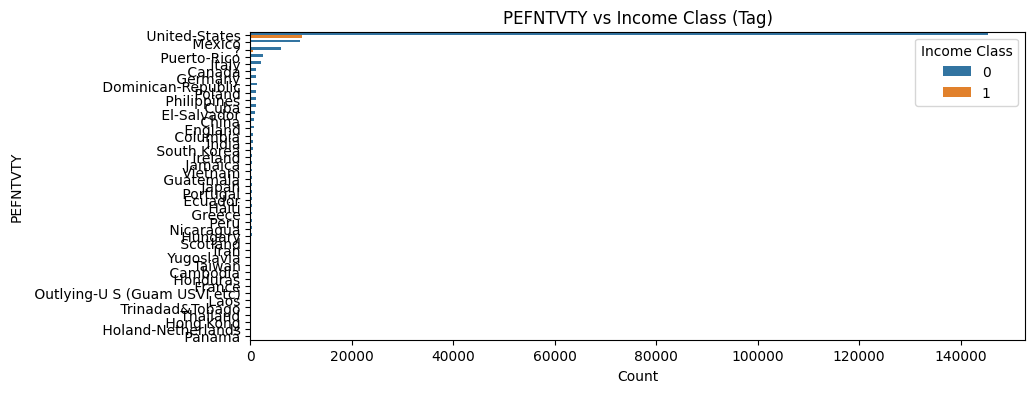

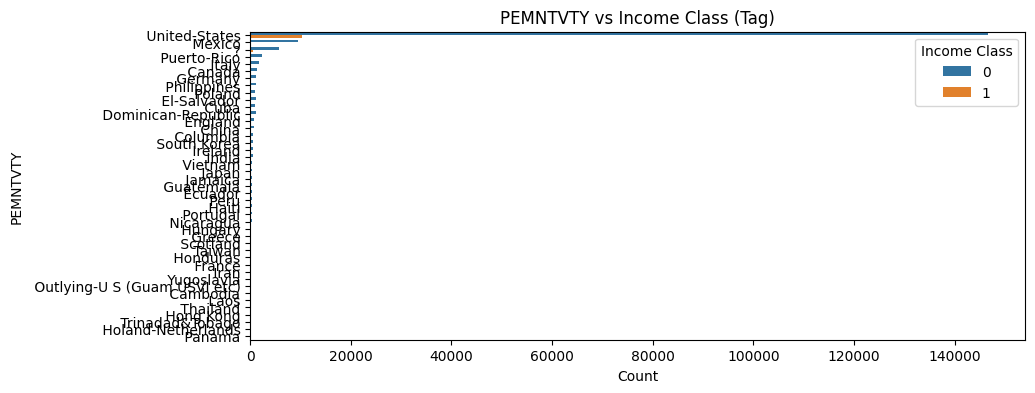

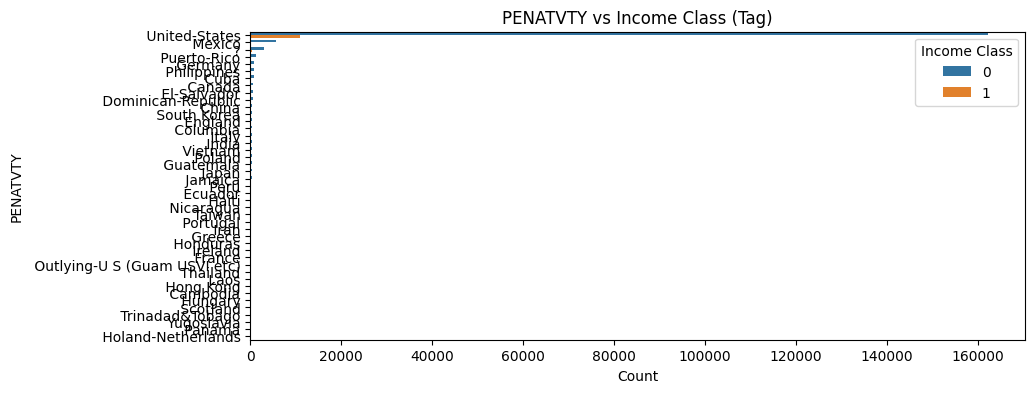

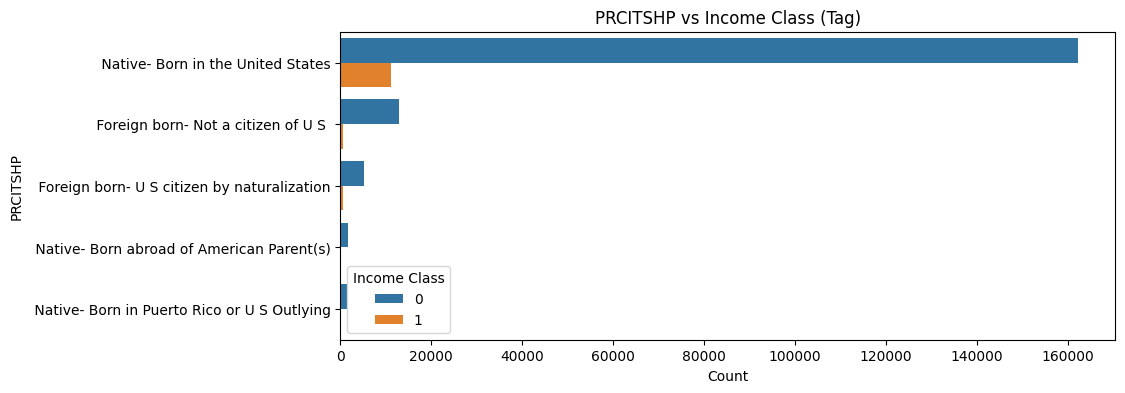

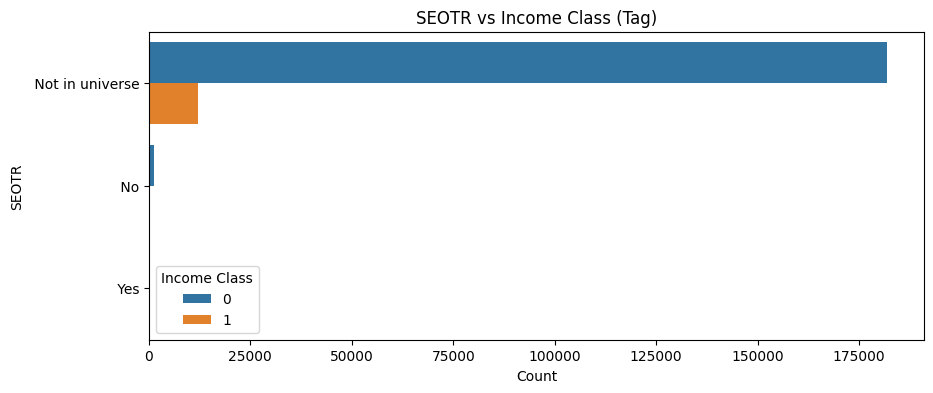

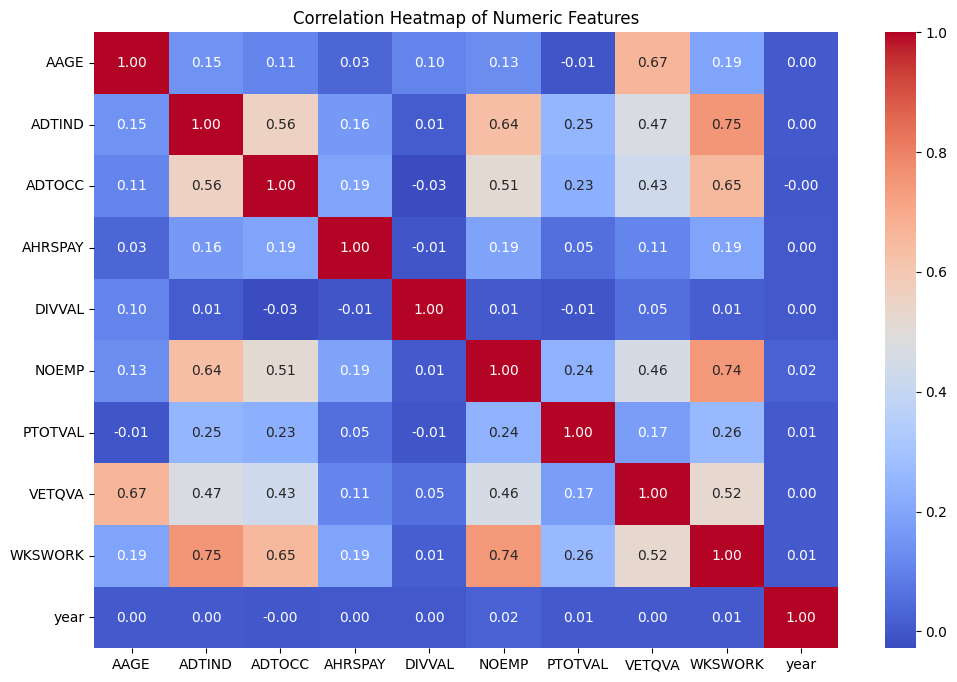

In [3]:
"""
Exploratory Data Analysis (EDA): Univariate and Bivariate Analysis

This script performs various visualizations to understand the dataset:

1. **Univariate Analysis:**
   - Categorical Features: Count plots to analyze distribution.
   - Continuous Features (CAPGAIN & CAPLOSS): Histograms with KDE to observe distributions.

2. **Bivariate Analysis:**
   - Categorical Features vs. Target (Tag): Count plots to compare feature distributions across income classes.
   - CAPGAIN & CAPLOSS: Special visualization using normalization and sorting by CAPGAIN.
   - Correlation Heatmap: Analyzes correlations between numerical features, excluding CAPGAIN, CAPLOSS, and MARSUPWT.

These visualizations help identify patterns, class imbalances, and feature relationships for predictive modeling.
"""

import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical columns (excluding MARSUPWT, CAPGAIN, CAPLOSS, and target 'Tag')
categorical_cols = [col for col in df_learn_cleaned.columns if col not in ['MARSUPWT', 'CAPGAIN', 'CAPLOSS', 'Tag', 'income', 'year'] and df_learn_cleaned[col].dtype == 'object']

# Univariate Analysis: Categorical Features
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(y=col, data=df_learn_cleaned, order=df_learn_cleaned[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

# Univariate Analysis: Continuous Features CAPGAIN & CAPLOSS
continuous_cols = ['CAPGAIN', 'CAPLOSS']
for col in continuous_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(df_learn_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Bivariate Analysis: Categorical vs Income ('Tag')
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(y=col, hue='Tag', data=df_learn_cleaned, order=df_learn_cleaned[col].value_counts().index)
    plt.title(f'{col} vs Income Class (Tag)')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.legend(title='Income Class')
    plt.show()

# Correlation heatmap for remaining numeric features (excluding CAPGAIN, CAPLOSS, MARSUPWT, Tag)
numeric_cols = [col for col in df_learn_cleaned.select_dtypes(include=['int64', 'float64']).columns if col not in ['MARSUPWT', 'Tag', 'CAPGAIN', 'CAPLOSS']]

if numeric_cols:
    plt.figure(figsize=(12,8))
    sns.heatmap(df_learn_cleaned[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

In [4]:
# Create a frequency table of 'AHSCOL' categories vs. income class ('Tag')
pd.crosstab(df_learn_cleaned['AHSCOL'], df_learn_cleaned['Tag'])

Tag,0,1
AHSCOL,,
College or university,5654,25
High school,6848,5
Not in universe,171125,12258


In [5]:
# Create a frequency table of 'GRINST' categories vs. income class ('Tag')
pd.crosstab(df_learn_cleaned['GRINST'], df_learn_cleaned['Tag'])

Tag,0,1
GRINST,,
?,662,45
Abroad,648,23
Alabama,210,6
Alaska,267,23
Arizona,239,4
Arkansas,197,6
California,1643,67
Colorado,228,11
Connecticut,105,12


In [6]:
# Create a frequency table of 'PARENT' categories vs. income class ('Tag')
pd.crosstab(df_learn_cleaned['PARENT'], df_learn_cleaned['Tag'])

Tag,0,1
PARENT,,
Both parents present,36105,2
Father only present,1871,0
Mother only present,12517,0
Neither parent present,1638,0
Not in universe,131496,12286


In [7]:
# Create a frequency table of 'SEOTR' categories vs. income class ('Tag')
pd.crosstab(df_learn_cleaned['SEOTR'], df_learn_cleaned['Tag'])

Tag,0,1
SEOTR,,
No,1375,214
Not in universe,181877,12058
Yes,375,16


In [8]:
# Create a frequency table of 'HHDFMX' categories vs. income class ('Tag')
pd.crosstab(df_learn_cleaned['HHDFMX'], df_learn_cleaned['Tag'])

Tag,0,1
HHDFMX,,
Child 18+ ever marr Not in a subfamily,990,23
Child 18+ ever marr RP of subfamily,659,12
Child 18+ never marr Not in a subfamily,11929,87
Child 18+ never marr RP of subfamily,587,2
Child 18+ spouse of subfamily RP,124,2
Child <18 ever marr RP of subfamily,9,0
Child <18 ever marr not in subfamily,36,0
Child <18 never marr RP of subfamily,80,0
Child <18 never marr not in subfamily,47217,2


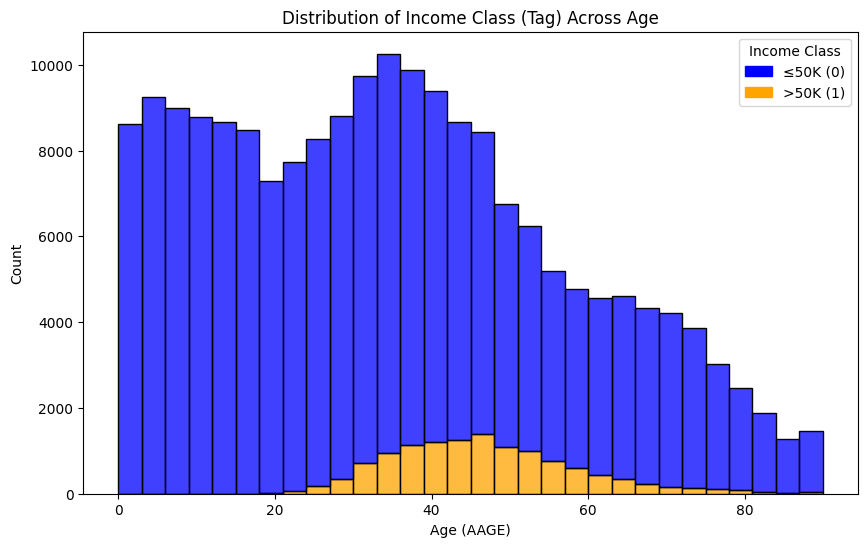

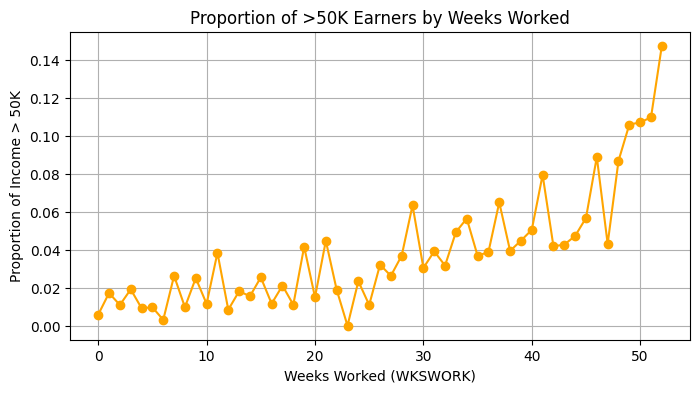

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_learn_cleaned,
    x='AAGE',
    hue='Tag',
    bins=30,
    multiple="stack",
    palette=["blue", "orange"],
    legend=False  # Disable Seaborn's auto-legend
)

plt.xlabel("Age (AAGE)")
plt.ylabel("Count")
plt.title("Distribution of Income Class (Tag) Across Age")

# Create custom legend patches
blue_patch = mpatches.Patch(color="blue", label="≤50K (0)")
orange_patch = mpatches.Patch(color="orange", label=">50K (1)")

plt.legend(handles=[blue_patch, orange_patch], title="Income Class", loc="upper right")
plt.show()

# Create custom legend patches for potential future usage, but don't show them right now
blue_patch = mpatches.Patch(color="blue", label="≤50K (0)")
orange_patch = mpatches.Patch(color="orange", label=">50K (1)")

# No plt.show() here, so nothing is displayed for the first snippet

# --- Now the second graph ---
# Compute the proportion of Tag=1 for each number of weeks worked
df_temp = (
    df_learn_cleaned
    .groupby('WKSWORK')['Tag']
    .mean()
    .reset_index()
    .rename(columns={'Tag': 'Proportion_Above50K'})
)

plt.figure(figsize=(8, 4))
plt.plot(df_temp['WKSWORK'], df_temp['Proportion_Above50K'], marker='o', color='orange')
plt.xlabel("Weeks Worked (WKSWORK)")
plt.ylabel("Proportion of Income > 50K")
plt.title("Proportion of >50K Earners by Weeks Worked")
plt.grid(True)
plt.show()  # Only the second graph is displayed

In [10]:
# Drop the columns to be dropped
df_learn_cleaned.drop(columns=['AHSCOL', 'GRINST', 'PARENT', 'SEOTR'], inplace=True)
df_test_cleaned.drop(columns=['AHSCOL', 'GRINST', 'PARENT', 'SEOTR'], inplace=True)
df_learn_cleaned.drop(columns=['MARSUPWT'], inplace=True)
df_test_cleaned.drop(columns=['MARSUPWT'], inplace=True)

print("Dropped columns 'AHSCOL', 'GRINST', 'PARENT', and 'SEOTR' due to low predictive value.")
print("Dropped column 'MARSUPWT' as per metadata instruction.")

Dropped columns 'AHSCOL', 'GRINST', 'PARENT', and 'SEOTR' due to low predictive value.
Dropped column 'MARSUPWT' as per metadata instruction.


In [11]:
# Define categorical columns and clean them by converting to string type 
# and stripping leading/trailing spaces using a vectorized regex operation.

# Categorical columns (including ACLSWKR)
categorical_cols = [
    "ACLSWKR", "AHGA", "AMARITL", "AMJIND", "AMJOCC", 
    "ARACE", "AREORGN", "ASEX", "AUNMEM", "AUNTYPE", "AWKSTAT", 
    "FILESTAT", "GRINREG", "HHDFMX", "HHDREL",  
    "MIGMTR1", "MIGMTR3", "MIGMTR4", "MIGSAME", "MIGSUN",  
    "PEFNTVTY", "PEMNTVTY", "PENATVTY", "PRCITSHP"
]

# Convert these columns to string type, then strip leading/trailing spaces using a single vectorized regex replacement
df_learn_cleaned[categorical_cols] = df_learn_cleaned[categorical_cols].astype(str).replace(
    to_replace=r'^\s+|\s+$',
    value='',
    regex=True
)
df_test_cleaned[categorical_cols] = df_test_cleaned[categorical_cols].astype(str).replace(
    to_replace=r'^\s+|\s+$',
    value='',
    regex=True
)

print("Stripped leading/trailing spaces from categorical columns (vectorized).")

Stripped leading/trailing spaces from categorical columns (vectorized).


In [12]:
# Reorganize 'HHDFMX' by keeping key categories and grouping all others as 'Other' 
# to reduce sparsity and improve model performance.

# Define the main categories to keep as-is
main_categories = {
    "Householder", 
    "Nonfamily householder", 
    "Secondary individual", 
    "Spouse of householder"
}

# Function to map HHDFMX values
def reorganize_hhdfmx(value):
    return value if value in main_categories else "Other"

# Apply transformation to both datasets
df_learn_cleaned['HHDFMX'] = df_learn_cleaned['HHDFMX'].apply(reorganize_hhdfmx)
df_test_cleaned['HHDFMX'] = df_test_cleaned['HHDFMX'].apply(reorganize_hhdfmx)

# Convert to categorical for better model efficiency
df_learn_cleaned['HHDFMX'] = df_learn_cleaned['HHDFMX'].astype('category')
df_test_cleaned['HHDFMX'] = df_test_cleaned['HHDFMX'].astype('category')

# Verify the transformation
print(df_learn_cleaned['HHDFMX'].value_counts())

HHDFMX
Other                    73068
Householder              53060
Spouse of householder    41571
Nonfamily householder    22107
Secondary individual      6109
Name: count, dtype: int64


In [13]:
# Encode categorical columns by assigning -1 for '?', 0 for 'Not in universe', 
# and sequential integers (starting from 1) for all other unique values.

# Robust encoding after space removal
def robust_encode_column(series):
    unique_vals = series.unique()
    
    encoding = {}
    if '?' in unique_vals:
        encoding['?'] = -1
    if 'Not in universe' in unique_vals:
        encoding['Not in universe'] = 0

    current_code = 1
    for val in sorted(unique_vals):
        if val not in ['?', 'Not in universe']:
            encoding[val] = current_code
            current_code += 1
    
    return series.map(encoding)

# Apply robust encoding
for col in categorical_cols:
    df_learn_cleaned[col] = robust_encode_column(df_learn_cleaned[col])
    df_test_cleaned[col] = robust_encode_column(df_test_cleaned[col])

print("Categorical columns encoded correctly.")
print(df_learn_cleaned[categorical_cols].head())

Categorical columns encoded correctly.
   ACLSWKR  AHGA  AMARITL  AMJIND  AMJOCC  ARACE  AREORGN  ASEX  AUNMEM  \
0        0    13        7      15       0      5        1     1       0   
1        6    17        1       5       8      5        1     2       0   
2        0     1        5      15       0      2        1     1       0   
3        0    11        5      15       0      5        1     1       0   
4        0    11        5      15       0      5        1     1       0   

   AUNTYPE  ...  HHDREL  MIGMTR1  MIGMTR3 MIGMTR4  MIGSAME  MIGSUN  PEFNTVTY  \
0        0  ...       7       -1       -1      -1        2      -1        40   
1        0  ...       5        3        7       8        1       2        40   
2        0  ...       1       -1       -1      -1        2      -1        41   
3        0  ...       3        7        6       7        3       0        40   
4        0  ...       3        7        6       7        3       0        40   

   PEMNTVTY  PENATVTY  PRCITS

In [14]:
# Create a new feature 'capgainloss' as the difference between 'CAPGAIN' and 'CAPLOSS', 
# then drop the original 'CAPGAIN', 'CAPLOSS', and 'income' columns to reduce redundancy.

df_learn_cleaned['capgainloss'] = df_learn_cleaned['CAPGAIN'] - df_learn_cleaned['CAPLOSS']
df_test_cleaned['capgainloss'] = df_test_cleaned['CAPGAIN'] - df_test_cleaned['CAPLOSS']

df_learn_cleaned.drop(columns=['CAPGAIN', 'CAPLOSS', 'income'], inplace=True)
df_test_cleaned.drop(columns=['CAPGAIN', 'CAPLOSS', 'income'], inplace=True)

print("Dropped columns 'CAPGAIN', 'CAPLOSS', 'income' due to redundancy.")

Dropped columns 'CAPGAIN', 'CAPLOSS', 'income' due to redundancy.


In [16]:
# Save the cleaned training and test datasets to CSV files in the same directory as the input files.

# Define output file paths (same directory as input files)
learn_output_path = "D:/Gursel/isguc/DataIku/census_income_learn_cleaned.csv"
test_output_path = "D:/Gursel/isguc/DataIku/census_income_test_cleaned.csv"

# Save cleaned DataFrames to CSV files
df_learn_cleaned.to_csv(learn_output_path, index=False)
df_test_cleaned.to_csv(test_output_path, index=False)

print(f"Cleaned training data saved to: {learn_output_path}")
print(f"Cleaned test data saved to: {test_output_path}")

Cleaned training data saved to: D:/Gursel/isguc/DataIku/census_income_learn_cleaned.csv
Cleaned test data saved to: D:/Gursel/isguc/DataIku/census_income_test_cleaned.csv


In [17]:
# Imports for model train, test, evaluation & visualization

# Basic imports
import pandas as pd
import numpy as np
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (
    roc_auc_score, roc_curve, classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score
)

# CatBoost for classification
from catboost import CatBoostClassifier, Pool

In [18]:
# Load the cleaned training and test datasets, remove any unwanted columns, 
# define feature and target variables, and optimize categorical data types for model efficiency.

# Paths to your cleaned datasets
train_path = 'D:/Gursel/isguc/DataIku/census_income_learn_cleaned.csv'
test_path = 'D:/Gursel/isguc/DataIku/census_income_test_cleaned.csv'

# Load main & validation data
train = pd.read_csv(train_path)
validation = pd.read_csv(test_path)

# Drop any 'Unnamed' columns if present (e.g., from previous saving issues)
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
validation = validation.loc[:, ~validation.columns.str.contains('^Unnamed')]

# Ensure correct feature columns (AFTER all feature engineering steps)
exclude_cols = ['Tag']  # Exclude only the target variable
feature_cols = [col for col in train.columns if col not in exclude_cols]

# Convert categorical columns to 'category' dtype for efficiency (CatBoost optimized)
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
train[categorical_cols] = train[categorical_cols].astype('category')
validation[categorical_cols] = validation[categorical_cols].astype('category')

# Separate X and y
X = train[feature_cols]
y = train['Tag'].values  # Target variable

# Same for validation set
X_val = validation[feature_cols]
y_val = validation['Tag'].values

# Print confirmation
print(f"Training set shape: {X.shape}, Target shape: {y.shape}")
print(f"Validation set shape: {X_val.shape}, Target shape: {y_val.shape}")

Training set shape: (195915, 35), Target shape: (195915,)
Validation set shape: (98760, 35), Target shape: (98760,)


In [19]:
# Train a CatBoostClassifier with cross-validation using StratifiedKFold, 
# optimizing for ROC AUC due to class imbalance. Evaluate model performance across folds.

# Define CatBoostClassifier for classification
model_cat = CatBoostClassifier(
    learning_rate=0.1,
    iterations=1610,
    depth=4,
    #rsm=0.89,
    l2_leaf_reg=1,
    eval_metric='AUC',        # for imbalanced classification, AUC is often good
    bagging_temperature=0.5,  # from zero to infinity
    logging_level='Silent',
    random_seed=1919,
    thread_count=8
)

# Create StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1919)

# Evaluate using cross_val_score with 'roc_auc'
cv_scores = cross_val_score(model_cat, X, y, cv=skf, scoring='roc_auc')

print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC: {cv_scores.mean():.4f}")
print(f"Std Dev ROC AUC: {cv_scores.std():.4f}")

Cross-Validation ROC AUC Scores: [0.95373621 0.95426491 0.95618736 0.95398523 0.95837571]
Mean ROC AUC: 0.9553
Std Dev ROC AUC: 0.0018


In [20]:
# Train the final CatBoost model on the full training set, measure training time, 
# make predictions on the validation set, and evaluate performance using key classification metrics.

# Fit the final model on ALL training data
t_start = time.time()
model_cat.fit(X, y)
t_end = time.time()
print(f"Time to train final model: {t_end - t_start:.2f} seconds")

# Predict on the validation set
y_val_pred_proba = model_cat.predict_proba(X_val)[:, 1]  # Probabilities for class=1
y_val_pred_class = model_cat.predict(X_val)              # 0/1 predictions

# Evaluate with common classification metrics
auc_score = roc_auc_score(y_val, y_val_pred_proba)
acc_score = accuracy_score(y_val, y_val_pred_class)
prec_score = precision_score(y_val, y_val_pred_class)
rec_score = recall_score(y_val, y_val_pred_class)
f1 = f1_score(y_val, y_val_pred_class)

print(f"\n--- Final Model Performance on Validation Set ---")
print(f"ROC AUC: {auc_score:.4f}")
print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_class, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_class))

Time to train final model: 58.75 seconds

--- Final Model Performance on Validation Set ---
ROC AUC: 0.9581
Accuracy: 0.9588
Precision: 0.7695
Recall: 0.4834
F1 Score: 0.5938

Classification Report:
              precision    recall  f1-score   support

           0     0.9665    0.9904    0.9783     92612
           1     0.7695    0.4834    0.5938      6148

    accuracy                         0.9588     98760
   macro avg     0.8680    0.7369    0.7861     98760
weighted avg     0.9543    0.9588    0.9544     98760

Confusion Matrix:
[[91722   890]
 [ 3176  2972]]


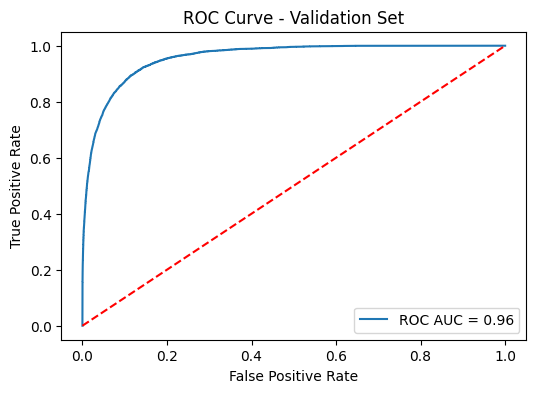

In [21]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],'r--')  # diagonal reference
plt.title('ROC Curve - Validation Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

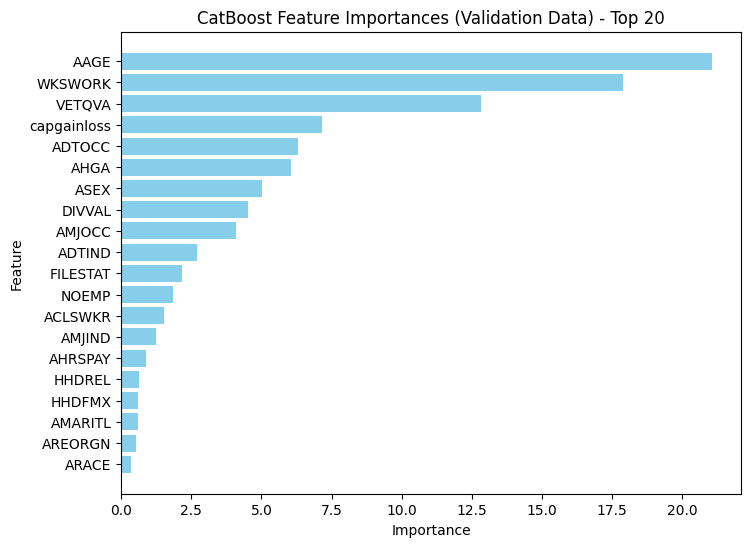

In [22]:
# Construct a Pool for the validation set
pool_val = Pool(X_val, label=y_val)

# Get feature importances using the validation set
importances_val = model_cat.get_feature_importance(pool_val)

# Pair each importance with its feature name
feature_importance_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance': importances_val
}).sort_values('importance', ascending=False)

# Plot the top N most important features
top_n = 20
top_features = feature_importance_df.head(top_n).sort_values('importance')

plt.figure(figsize=(8,6))
plt.barh(y=top_features['feature'], width=top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'CatBoost Feature Importances (Validation Data) - Top {top_n}')
plt.show()

In [23]:
# Train second model - Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

# Define RandomForestClassifier
model_rf = RandomForestClassifier(
    n_estimators=377,
    max_depth=7,
    min_samples_split=3,
    class_weight=None,    # or 'balanced' if you want to handle imbalance 
    random_state=1919,
    n_jobs=-1            # Use all CPU cores
)

# Create StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1919)

# Evaluate using cross_val_score with 'roc_auc'
cv_scores = cross_val_score(model_rf, X, y, cv=skf, scoring='roc_auc')

print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC: {cv_scores.mean():.4f}")
print(f"Std Dev ROC AUC: {cv_scores.std():.4f}")

Cross-Validation ROC AUC Scores: [0.93776306 0.93610446 0.93816269 0.93675708 0.94124358]
Mean ROC AUC: 0.9380
Std Dev ROC AUC: 0.0018


In [24]:
# Train the final Random Forest model on the full training set, measure training time, 
# make predictions on the validation set, and evaluate performance using key classification metrics.

import time
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, classification_report, confusion_matrix
)

# Fit the final Random Forest on ALL training data
t_start = time.time()
model_rf.fit(X, y)
t_end = time.time()
print("Time to train final model: {t_end - t_start:.2f}")

# Predict on the validation set
y_val_pred_proba = model_rf.predict_proba(X_val)[:, 1]  # Probability of class=1
y_val_pred_class = model_rf.predict(X_val)

# Evaluate with classification metrics
auc_score = roc_auc_score(y_val, y_val_pred_proba)
acc_score = accuracy_score(y_val, y_val_pred_class)
prec_score = precision_score(y_val, y_val_pred_class)
rec_score = recall_score(y_val, y_val_pred_class)
f1 = f1_score(y_val, y_val_pred_class)

print(f"\n--- Final Model Performance on Validation Set ---")
print(f"ROC AUC: {auc_score:.4f}")
print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_class, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_class))

Time to train final model: {t_end - t_start:.2f}

--- Final Model Performance on Validation Set ---
ROC AUC: 0.9399
Accuracy: 0.9455
Precision: 0.8692
Recall: 0.1470
F1 Score: 0.2515

Classification Report:
              precision    recall  f1-score   support

           0     0.9463    0.9985    0.9717     92612
           1     0.8692    0.1470    0.2515      6148

    accuracy                         0.9455     98760
   macro avg     0.9078    0.5728    0.6116     98760
weighted avg     0.9415    0.9455    0.9269     98760

Confusion Matrix:
[[92476   136]
 [ 5244   904]]


In [25]:
# Train third model - :ogistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define LogisticRegression
model_lr = LogisticRegression(
    penalty='l2',
    C=1,                  # inverse of regularization strength
    solver='liblinear',     # liblinear, lbfgs, newton-cg, sag, saga
    random_state=1919
)

# Create StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1919)

# Evaluate using cross_val_score with 'roc_auc'
cv_scores = cross_val_score(model_lr, X, y, cv=skf, scoring='roc_auc')

print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC: {cv_scores.mean():.4f}")
print(f"Std Dev ROC AUC: {cv_scores.std():.4f}")

Cross-Validation ROC AUC Scores: [0.92331848 0.92324523 0.92527883 0.92351735 0.92810162]
Mean ROC AUC: 0.9247
Std Dev ROC AUC: 0.0019


In [26]:
# Train the final Logistic Regression model on the full training set, measure training time, 
# make predictions on the validation set, and evaluate performance using key classification metrics.

import time
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, classification_report, confusion_matrix
)

# Fit the final Logistic Regression on ALL training data
t_start = time.time()
model_lr.fit(X, y)
t_end = time.time()
print(f"Time to train final model: {t_end - t_start:.2f} seconds")

# Predict on the validation set
y_val_pred_proba = model_lr.predict_proba(X_val)[:, 1]  # Probability of class=1
y_val_pred_class = model_lr.predict(X_val)

# Evaluate with classification metrics
auc_score = roc_auc_score(y_val, y_val_pred_proba)
acc_score = accuracy_score(y_val, y_val_pred_class)
prec_score = precision_score(y_val, y_val_pred_class)
rec_score = recall_score(y_val, y_val_pred_class)
f1 = f1_score(y_val, y_val_pred_class)

print("\n--- Final Model Performance on Validation Set ---")
print(f"ROC AUC: {auc_score:.4f}")
print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_class, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_class))

Time to train final model: 11.34 seconds

--- Final Model Performance on Validation Set ---
ROC AUC: 0.9274
Accuracy: 0.9470
Precision: 0.6989
Recall: 0.2598
F1 Score: 0.3788

Classification Report:
              precision    recall  f1-score   support

           0     0.9528    0.9926    0.9723     92612
           1     0.6989    0.2598    0.3788      6148

    accuracy                         0.9470     98760
   macro avg     0.8259    0.6262    0.6755     98760
weighted avg     0.9370    0.9470    0.9353     98760

Confusion Matrix:
[[91924   688]
 [ 4551  1597]]
